# Clinical Trials Data Processing

## Goal

- To get a basic data processing pipeline outlined 
- To get the results we need to build a MVP 
- To understand future steps for more advanced study p

## TODOS
- Compare results filtering with the number of results from the GUI
- Parse all studies into workable CSVs with certain attributes 
- Create a safe method for getting values from the JSON file withought killin the study 
- Add in objective flags for measurement types
- Get the P-Values with the other types
- Add in the demographics to the csv
- Look at the missed values and see if the studies are really missing data 


In [1]:
# I think we just need to get all the studies and filter out the ones with results manually 
# We can make a module for this later
# The conditions can be easily parsed but we need to bucket them -> maybe make a model for that??
# The demographics are the easiest to get out of this
# Effectiveness - this can be done by averaging the difference between placebo and results, thought we 
# first have to filter the studies that have a placebo 
#
# Fields to be 

In [1]:
import requests
import pandas as pd
import scipy.stats as stats 
import nltk
import seaborn as sns
import numpy as np

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
API_BASE_URL='https://clinicaltrials.gov/api/query'
EXAMPLE_DRUG='gabapentin'

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/porterhunley/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/porterhunley/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/porterhunley/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Interfacing with ClinicalTrials.gov
- TODO: need to get all the studies not just the ones in a certain range 
- It's also worth noting that we can download all of this data

In [3]:
# First a basic API interface

def get_studies_by_expression(expression):
    r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk=1&max_rnk=99&fmt=json'
                     .format(expr=expression))
    return r.json()

def get_conditions_for_drug(drug):
    r = requests.get(API_BASE_URL + '/field_values?expr={drug}&field=ConditionAncestorTerm&fmt=json'
                     .format(drug=drug))
    
    return r.json()

In [4]:
def get_all_studies(expr, results=True):
    og_length = 99
    studies = []
    count = 0
    while (og_length >= 99):
        r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk={min_rank}&max_rnk={max_rank}&fmt=json'
                         .format(expr=expr, min_rank=count*99 + 1, max_rank=(count*99+1)+98))
        og_length = len(r.json()['FullStudiesResponse'].get('FullStudies', []))
        new_studies = r.json()['FullStudiesResponse'].get('FullStudies', [{'Study': []}])
        studies += list(filter(lambda x: 'ResultsSection' in x['Study'] and 'OutcomeMeasuresModule' in x['Study']['ResultsSection'], new_studies))
        count+=1
        
    return studies


## Study Processing

- Filter out useless studies san results 
- Parse out useful values from the tree: place
- Create a dataframe for the other aspects of drug 

In [5]:
# Get all studies for all conditions for a given drug
# studies = []
# for condition in conditionsDf[0:3]['Conditions'].tolist():
#     print(EXAMPLE_DRUG + ' AND AREA[ConditionAncestorTerm]{}'.format(condition))
#     studies += get_all_studies(EXAMPLE_DRUG + ' AND AREA[ConditionAncestorTerm]{}'.format(condition))
    

### Parsing data
- Need to reduce the attrition rate for all the studies
- Let's get all the following into a csv -> a function for each

In [6]:
# Get all studies relating to the example drug 
studies = get_all_studies(EXAMPLE_DRUG)
len(studies)

119

### Create Tables
- Studies
- Groups
- Outcomes
- Measures

We need a good relational model to analyze this data fully

In [7]:
def create_studies_table(studies, drug):
    buffer = {
        'study_id': [], 'name': [], 'drug': [], 'conditions': [], 
        'verified_date': [], 'responsible_party': [], 'type': [], 'description': [],
        'interventions': [], 'purpose': [], 'intervention_type': [], 'mesh_terms': []
              
         }
    for i, study in enumerate(studies):


        buffer['drug'].append(drug)
        try:
            buffer['study_id'].append(study['Study']['ProtocolSection']['IdentificationModule']['NCTId'])
        except KeyError as e:
            buffer['study_id'].append('NA')

        try:
            buffer['name'].append(study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        except KeyError as e:
            buffer['name'].append('NA')

        try:
            buffer['verified_date'].append(study['Study']['ProtocolSection']['StatusModule']['StatusVerifiedDate'])
        except KeryError as e:
            buffer['verified_date'].append('NA')

        try:
            buffer['responsible_party'].append(study['Study']['ProtocolSection']['SponsorCollaboratorsModule']['ResponsibleParty'])
        except KeyError as e:
            buffer['responsible_party'].append('NA')

        try: 
            buffer['conditions'].append(study['Study']['ProtocolSection']['ConditionsModule']['ConditionList']['Condition'])
        except KeyError as e:
            buffer['conditions'].append('NA')

        try:
            buffer['type'].append(study['Study']['ProtocolSection']['DesignModule']['StudyType'])
        except KeyError as e:
            buffer['type'].append('NA')
        
        buffer['purpose'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo'].get('DesignPrimaryPurpose', 'NA'))
        buffer['intervention_type'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo'].get('DesignInterventionModel', 'NA'))
        
        try:
            buffer['mesh_terms'].append([x.get('ConditionMeshTerm', 'NA') for x in study['Study']['DerivedSection']['ConditionBrowseModule']['ConditionMeshList']['ConditionMesh']])
        except KeyError as e:
            buffer['mesh_terms'].append([])
            
        try:
            buffer['description'].append(study['Study']['ProtocolSection']['DescriptionModule']['DetailedDescription'])
        except KeyError as e:
            buffer['description'].append('NA')
            
        try: 
            buffer['interventions'].append([x.get('InterventionMeshTerm', 'NA') for x in study['Study']['DerivedSection']['InterventionBrowseModule']['InterventionMeshList']['InterventionMesh']])
        except KeyError as e:
            buffer['interventions'].append([])
    
    return buffer
studies_df = pd.DataFrame.from_dict(create_studies_table(studies, EXAMPLE_DRUG))
studies_df.head()

,study_id,name,drug,conditions,verified_date,responsible_party,type,description,interventions,purpose,intervention_type,mesh_terms
0,NCT01675960,"A Phase II, Randomized, Placebo-controlled, Do...",gabapentin,"[Neurologically Impaired, Irritable Mood, Sign...",July 2019,{'ResponsiblePartyType': 'Sponsor'},Interventional,"This is a randomized, placebo-controlled, cros...",[Gabapentin],Treatment,Crossover Assignment,"[Sleep Initiation and Maintenance Disorders, C..."
1,NCT02359110,Administration of Pre-Operative Gabapentin to ...,gabapentin,[Postoperative Pain],March 2018,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,The purpose of this study is to prospectively ...,[Gabapentin],Treatment,Parallel Assignment,"[Pain, Postoperative]"
2,NCT01977937,Pain Control in Pediatric Posterior Spine Fusi...,gabapentin,"[Pain, Postoperative]",May 2019,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,Patients aged 10-19 years with idiopathic scol...,[Gabapentin],Treatment,Parallel Assignment,"[Pain, Postoperative]"
3,NCT03334903,Gabapentin Regimens and Their Effects on Opioi...,gabapentin,"[Knee Osteoarthritis, Knee Pain Chronic, Opioi...",February 2021,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,The purpose of this study is to determine the ...,[Gabapentin],Treatment,Parallel Assignment,"[Osteoarthritis, Knee, Opioid-Related Disorders]"
4,NCT02052414,"Open Labeled, Non-randomized, Study of Efficac...",gabapentin,[Fibromyalgia],September 2016,{'ResponsiblePartyType': 'Sponsor'},Interventional,Subject must carry a diagnosis of fibromyalgia...,[Gabapentin],Treatment,Single Group Assignment,"[Fibromyalgia, Myofascial Pain Syndromes]"


In [8]:
studies_df[studies_df['interventions'].apply(len) == 0]

,study_id,name,drug,conditions,verified_date,responsible_party,type,description,interventions,purpose,intervention_type,mesh_terms
90,NCT01426230,"A Phase 4, Open Label, Study of Safety and Eff...",gabapentin,[Post Herpetic Neuralgia],March 2013,{'ResponsiblePartyType': 'Sponsor'},Observational,"Open Label, single arm, 2wk titration, 6 wk st...",[],NA,NA,"[Neuralgia, Neuralgia, Postherpetic]"
94,NCT01332305,"A Randomized, Double-Blind, Placebo-Controlled...",gabapentin,[Restless Legs Syndrome],May 2011,{'ResponsiblePartyType': 'Sponsor'},Interventional,"This was a multicenter, randomized, double bli...",[],Treatment,Parallel Assignment,"[Psychomotor Agitation, Restless Legs Syndrome..."
111,NCT02186795,Improvement in Total Hip Arthroplasty Patient ...,gabapentin,"[Arthroplasty, Replacement, Hip, Arthritis]",June 2018,{'ResponsiblePartyType': 'Principal Investigat...,Observational,Primary outcome: 48 hour opiate consumption in...,[],NA,NA,[Arthritis]
113,NCT00404248,Phase I/II Study of Intravenous Infusion of Te...,gabapentin,[Brain and Central Nervous System Tumors],March 2019,{'ResponsiblePartyType': 'Sponsor'},Interventional,OBJECTIVES:\n\nPrimary\n\nDetermine the maximu...,[],Treatment,Parallel Assignment,"[Nervous System Neoplasms, Central Nervous Sys..."
114,NCT03330119,"Determining the Effect of an ""Alternate Recove...",gabapentin,"[Pregnancy Related, Narcotic Use]",March 2021,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,"""Enhanced recovery"" is a multi-modal, evidence...",[],Supportive Care,Parallel Assignment,[]
116,NCT03975790,Comparative Analysis of Outcomes Among Patient...,gabapentin,[Rheumatoid Arthritis],September 2019,{'ResponsiblePartyType': 'Sponsor'},Observational,NA,[],NA,NA,"[Arthritis, Arthritis, Rheumatoid]"


#### Groups Table
The control or placebo group that gets nothing 
- Name
- Study
- Id
- Number of participants 
- Description

In [9]:
def create_groups_table(studies): # The groups in the baseline -> this might end up badly 
    groups_df = { 
        'name': [],
        'study_id': [],
        'id': [],
        'description': [],
        'participants': [],
        'maybe_arm_type': []
    }
    parts = []
    for study in studies:
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        groups = []
        denoms = []
        try: 
            groups = study['Study']['ResultsSection']['BaselineCharacteristicsModule']['BaselineGroupList']['BaselineGroup']
        except KeyError as e:
            groups = []
            
        # Get the type of groups from arm 
        arms = study['Study']['ProtocolSection']['ArmsInterventionsModule']['ArmGroupList'].get('ArmGroup', [])
        types = []
        for arm in arms:
            label = arm.get('ArmGroupLabel', None)
            armType = arm.get('ArmGroupType', None)
            types.append(armType)
            
        for i, group in enumerate(groups):
            groups_df['name'].append(group.get('BaselineGroupTitle', 'NA'))
            groups_df['study_id'].append(study_id)
            groups_df['id'].append(group.get('BaselineGroupId', 'NA'))
            groups_df['description'].append(group.get('BaselineGroupDescription'))
            groups_df['maybe_arm_type'].append(types[i] if i<len(types)else 'NA')
                
        try:
            denoms = study['Study']['ResultsSection']['BaselineCharacteristicsModule']['BaselineDenomList']['BaselineDenom']
        except KeyError as e:
            denoms = []
            
        participants = list(filter(lambda x: x.get('BaselineDenomUnits', 'NA') == 'Participants', denoms))
        for participant in participants[0]['BaselineDenomCountList']['BaselineDenomCount']:
            groups_df['participants'].append(int(participant['BaselineDenomCountValue']))
            

    
    return groups_df, parts
        
groups = pd.DataFrame.from_dict(create_groups_table(studies)[0])
groups

,name,study_id,id,description,participants,maybe_arm_type
0,"Gabapentin, Then Placebo",NCT01675960,BG000,Participants first receive gabapentin 3 times ...,2,Experimental
1,"Placebo, Then Gabapentin",NCT01675960,BG001,Participants first receive placebo 3 times per...,0,Experimental
2,Total,NCT01675960,BG002,Total of all reporting groups,2,NA
3,Gabapentin,NCT02359110,BG000,Patients will receive Gabapentin 300mg tab les...,55,Experimental
4,Placebo,NCT02359110,BG001,Patients will receive Methylcellulose based pl...,54,Placebo Comparator
...,...,...,...,...,...,...
376,Pregabalin,NCT01524796,BG000,Participants who were diagnosed with periphera...,128,None
377,A: Localized Resectable Disease,NCT00667342,BG000,Stratum A participants had primary tumors pote...,31,Experimental
378,B: Localized Unresectable Disease,NCT00667342,BG001,Participants with localized unresectable prima...,0,Experimental
379,C: Metastatic Tumors,NCT00667342,BG002,Stratum C participants had metastatic tumors.,12,Experimental


#### Measures Table
- Study Id
- title
- Type 
- Description
- Disperision param
- Measure Param
- Units

In [10]:
def get_outcome_modules(studies):
    outcome_modules = []
    for study in studies:
        if 'OutcomeMeasuresModule' in study['Study']['ResultsSection']:
            outcome_modules.append(study['Study']['ResultsSection']['OutcomeMeasuresModule'])
            continue 
        print('No Results: ', study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        
    return outcome_modules

def create_measures_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'type': [],
        'description': [],
        'dispersion_param': [],
        'measure_param': [],
        'units': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            df['type'].append(measure.get('OutcomeMeasureType', 'NA'))
            df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
            df['description'].append(measure.get('OutcomeMeasureDescription', 'NA'))
            df['measure_param'].append(measure.get('OutcomeMeasureParamType', 'NA'))
            df['dispersion_param'].append(measure.get('OutcomeMeasureDispersionType', 'NA'))
            df['units'].append(measure.get('OutcomeMeasureUnitOfMeasure', 'NA'))
            df['study_id'].append(study_id)
            
    return df 

measures = pd.DataFrame.from_dict(create_measures_table(studies)).drop_duplicates(['study_id', 'measure'])
measures.head()

,study_id,measure,type,description,dispersion_param,measure_param,units
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA
2,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale
3,NCT02359110,VAS (Visual Analog Scale),Secondary,The VAS is scored using a horizontal line 100m...,95% Confidence Interval,Least Squares Mean,units on a scale
4,NCT02359110,Total Morphine Consumption,Secondary,NA,Standard Deviation,Mean,mg


In [11]:
measures[measures['type'] == 'Primary']['units'].value_counts()

participants                      73
Participants                      54
units on a scale                  30
score on a scale                  14
Units on a scale                   8
                                  ..
mg/kg/h                            1
milligrams                         1
morphine milligram equivalents     1
cumulative hydrocodone (mg/kg)     1
Z-statistic                        1
Name: units, Length: 80, dtype: int64

#### Outcomes Table
- Study_id
- Group_id
- Type
- Title
- Measure
- Unit
- Time
- Dispersion
- Upper 
- Lower
- Value 


In [12]:
'''
We need to create disjoint tables :( 
'''
    
# def make_outcomes_map(measure):
#     mp = {}
#     for group in measure.get('OutcomeClassList', {'OutcomeClass': []})['OutcomeClass']:
#         mp['classTitle'] = group.get('OutcomeClassTitle', 'NA')
        
#         for cat in group.get('OutcomeCategoryList', {'OutcomeCategory': []})['OutcomeCategory']:
#             for outcome in cat['OutcomeMeasurementList']['OutcomeMeasurement']:
#                 mp[outcome['OutcomeMeasurementGroupId']] = outcome
#     return mp
                
                
def create_outcomes_table(studies):
    outcome_modules = get_outcome_modules(studies)
    admin_df = {
        'study_id': [],
        'group_id': [],
        'measure': [],
        'title': [],
        'description': [],
    }
    
    outcome_df = {
        'study_id': [],
        'group_id': [],
        'measure': [],
        'title': [],
        'value': [],
        'dispersion': [],
        'upper': [],
        'lower': [],
        'participants': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            try:
                overall_group_to_no = {}
                for denom in measure.get('OutcomeDenomList', {'OutcomeDenom': []})['OutcomeDenom']:
                    if denom.get('OutcomeDenomUnits', 'NA') == 'Participants':
                        for count in denom.get('OutcomeDenomCountList', {'OutcomeDenomCount': []})['OutcomeDenomCount']:
                            overall_group_to_no[count['OutcomeDenomCountGroupId']] = count['OutcomeDenomCountValue']
                                
                for admin in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                    admin_df['study_id'].append(study_id)
                    admin_df['group_id'].append(admin.get('OutcomeGroupId', 'NA'))
                    admin_df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
                    admin_df['title'].append(admin.get('OutcomeGroupTitle', 'NA'))
                    admin_df['description'].append(admin.get('OutcomeGroupDescription', 'NA'))
                    
                # Sometimes the participants are just listed one time before all the others - not just in the class
                for group in measure.get('OutcomeClassList', {'OutcomeClass': []})['OutcomeClass']:
    
                    group_to_no = {}
                    for denom in group.get('OutcomeClassDenomList', {'OutcomeClassDenom': []})['OutcomeClassDenom']:
                        for count in denom.get('OutcomeClassDenomCountList', {'OutcomeClassDenomCount': []})['OutcomeClassDenomCount']:
                            group_to_no[count['OutcomeClassDenomCountGroupId']] = count['OutcomeClassDenomCountValue']

                    for cat in group.get('OutcomeCategoryList', {'OutcomeCategory': []})['OutcomeCategory']:
                        for outcome in cat['OutcomeMeasurementList']['OutcomeMeasurement']:
                            outcome_df['study_id'].append(study_id)
                            outcome_df['group_id'].append(outcome.get('OutcomeMeasurementGroupId', 'NA'))
                            outcome_df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
                            outcome_df['value'].append(outcome.get('OutcomeMeasurementValue', 'NA'))
                            outcome_df['dispersion'].append(outcome.get('OutcomeMeasurementSpread', 'NA'))
                            outcome_df['upper'].append(outcome.get('OutcomeMeasurementUpperLimit', 'NA'))
                            outcome_df['lower'].append(outcome.get('OutcomeMeasurementLowerLimit', 'NA'))
                            outcome_df['participants'].append(group_to_no.get(outcome.get('OutcomeMeasurementGroupId', 'NA'), None) or overall_group_to_no.get(outcome.get('OutcomeMeasurementGroupId', 'NA'), 'NA'))
                            outcome_df['title'].append(group.get('OutcomeClassTitle', 'NA'))
                        
                    
            except KeyError as e:
                print(e)
                continue
                
    return (admin_df, outcome_df)
        
admin_df, outcome_df = create_outcomes_table(studies)
administrations = pd.DataFrame.from_dict(admin_df)
outcomes = pd.DataFrame.from_dict(outcome_df)

In [13]:
outcomes

,study_id,group_id,measure,title,value,dispersion,upper,lower,participants
0,NCT02359110,OG000,NRS (Numerical Rating Scale),Hour 2,3.5,NA,4.5,2.6,46
1,NCT02359110,OG001,NRS (Numerical Rating Scale),Hour 2,3.4,NA,4.4,2.5,49
2,NCT02359110,OG000,NRS (Numerical Rating Scale),Hour 4,5.4,NA,6.5,4.3,28
3,NCT02359110,OG001,NRS (Numerical Rating Scale),Hour 4,5.5,NA,6.7,4.3,25
4,NCT02359110,OG000,NRS (Numerical Rating Scale),Hour 6,5.3,NA,6.5,4.2,30
...,...,...,...,...,...,...,...,...,...
6674,NCT00667342,OG001,Median Duration of Neuropathic Pain Medication,NA,7.0,NA,29.9,1.7,16
6675,NCT00667342,OG002,Median Duration of Neuropathic Pain Medication,NA,7.0,NA,30.0,1.7,26
6676,NCT00667342,OG000,Mean Duration of Neuropathic Pain Medication,NA,9.0,8.0,NA,NA,10
6677,NCT00667342,OG001,Mean Duration of Neuropathic Pain Medication,NA,9.8,8.4,NA,NA,16


In [14]:
administrations

,study_id,group_id,measure,title,description
0,NCT01675960,OG000,Symptom Relief for Chronic Irritability in Neu...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...
1,NCT01675960,OG001,Symptom Relief for Chronic Irritability in Neu...,Placebo,Glycerin based clear solution that is flavored...
2,NCT01675960,OG000,Prevalence of Associated Gastrointestinal and ...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...
3,NCT01675960,OG001,Prevalence of Associated Gastrointestinal and ...,Placebo,Glycerin based clear solution that is flavored...
4,NCT02359110,OG000,NRS (Numerical Rating Scale),Gabapentin,Patients will receive Gabapentin 300mg tab les...
...,...,...,...,...,...
2244,NCT00667342,OG001,Median Duration of Neuropathic Pain Medication,Limb Sparing Group,Participants had localized disease at diagnosi...
2245,NCT00667342,OG002,Median Duration of Neuropathic Pain Medication,Entire Study Group,Participants enrolled on the study who met the...
2246,NCT00667342,OG000,Mean Duration of Neuropathic Pain Medication,Amputation Group,Participants had metastatic disease at diagnosis.
2247,NCT00667342,OG001,Mean Duration of Neuropathic Pain Medication,Limb Sparing Group,Participants had localized disease at diagnosi...


In [15]:
# Now we actually need to add in the doses
# This is going to be tricky as the groups have sepperate doses
#Put it all together
units_map = {
    'milligram': 'mg',
    'kilogram': 'kg',
    'gram': 'g'
            }
def clean_doses_map(doses_map, hitlist):
    units = []
    nums_map = {}
    for num in doses_map:
        unit = []
        for word in doses_map[num]:
            if word in hitlist:
                unit.append(units_map[word] if word in units_map else word)
            elif '/' in word:
                unit.append('/'.join(filter(lambda x: x in hitlist, word.split('/'))))
        nums_map[num] = ''.join(unit).replace('per', '/')
    return nums_map

def check_trailings_for_measures(trailings, hitlist):
    mask = []
    for trailing in trailings:
        flag = False
        for word in trailing:
            if (word in hitlist) or ('/' in word):
                flag = True
        mask.append(flag)

    return mask

def get_nums_trailings(trailings, nums, hitlist):
    mask = check_trailings_for_measures(trailings, hitlist)
    return {nums[i]:trailings[i] for i in range(len(nums)) if mask[i]}
        
doses_hit_list = ['mg', 'g', 'kg', 'milligram', 'kilogram', 'gram', 'per']
doses_hit_list += [x+'/' for x in doses_hit_list]

stemmer = nltk.stem.PorterStemmer()
def apply_to_nested_list(nested_list, func):
    for i, lst in enumerate(nested_list):
        lst = [func(x) for x in lst]
        nested_list[i] = lst
    return nested_list

def get_numbers(string):
    nums= []
    curr_num= []
    for char in string:
        if char.isdigit():
            curr_num.append(char)
        elif curr_num:
            nums.append(int(''.join(curr_num)))
            curr_num = []
            
    return nums

def get_trailing_words(string, nums):
    trailings = []
    for num in nums:
        trailings.append([x.replace('.', '').replace('(','').replace(')','') for x in string.split(str(num))[1].split()[0:3]])
    return trailings

def get_doses(string): #Typically the string is the description
    nums = get_numbers(string)
    trailings = get_trailing_words(string, nums)
    stemmed = apply_to_nested_list(trailings, stemmer.stem)
    return clean_doses_map(get_nums_trailings(stemmed, nums, doses_hit_list), doses_hit_list)
    

administrations['dose'] = administrations['description'].apply(get_doses)
administrations

,study_id,group_id,measure,title,description,dose
0,NCT01675960,OG000,Symptom Relief for Chronic Irritability in Neu...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,{40: 'mg/kg'}
1,NCT01675960,OG001,Symptom Relief for Chronic Irritability in Neu...,Placebo,Glycerin based clear solution that is flavored...,{}
2,NCT01675960,OG000,Prevalence of Associated Gastrointestinal and ...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,{40: 'mg/kg'}
3,NCT01675960,OG001,Prevalence of Associated Gastrointestinal and ...,Placebo,Glycerin based clear solution that is flavored...,{}
4,NCT02359110,OG000,NRS (Numerical Rating Scale),Gabapentin,Patients will receive Gabapentin 300mg tab les...,{300: 'mg'}
...,...,...,...,...,...,...
2244,NCT00667342,OG001,Median Duration of Neuropathic Pain Medication,Limb Sparing Group,Participants had localized disease at diagnosi...,{}
2245,NCT00667342,OG002,Median Duration of Neuropathic Pain Medication,Entire Study Group,Participants enrolled on the study who met the...,{}
2246,NCT00667342,OG000,Mean Duration of Neuropathic Pain Medication,Amputation Group,Participants had metastatic disease at diagnosis.,{}
2247,NCT00667342,OG001,Mean Duration of Neuropathic Pain Medication,Limb Sparing Group,Participants had localized disease at diagnosi...,{}


### Create Statistics 
- This is an interesting task because some of the studies have their own stats which we probably want to trust??

We need to bubble up the stats from the bottom, this means that each measure needs it's own results, then
we can interperate all the results on a higher level with the study

Generally we need some stats rows for each measure since we need to retrieve the ones that may or may not be a part of
the study

#### Stats table 
- Get the analysis from the existing measures if there is any 

In [16]:
def create_analytics_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'groups': [],
        'description': [], # may or may not be the outcome title
        'method': [],
        'param_type': [],
        'fromStudy': [],
        'pval': [],
        'group_titles': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            group_to_title = {}
            for group in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                if group['OutcomeGroupId'] not in group_to_title:
                    group_to_title[group['OutcomeGroupId']] = 'NA'
                group_to_title[group['OutcomeGroupId']] = group.get('OutcomeGroupTitle', 'NA')
                    
            measure_title = measure.get('OutcomeMeasureTitle', 'NA')
            for stat in measure.get('OutcomeAnalysisList', {'OutcomeAnalysis': []})['OutcomeAnalysis']:
                df['study_id'].append(study_id)
                df['measure'].append(measure_title)
                df['groups'].append(stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId'])
                df['description'].append(stat.get('OutcomeAnalysisGroupDescription', 'NA'))
                df['method'].append(stat.get('OutcomeAnalysisStatisticalMethod', 'NA'))
                df['param_type'].append(stat.get('OutcomeAnalysisParamType', 'NA'))
                df['fromStudy'].append(True)
                df['pval'].append(stat.get('OutcomeAnalysisPValue', 'NA'))
                df['group_titles'].append(dict([(g, group_to_title.get(g, 'NA')) for g in stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId']]))
    return df

analytics = pd.DataFrame.from_dict(create_analytics_table(studies))
analytics

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
4,NCT02359110,VAS (Visual Analog Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.52,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
...,...,...,...,...,...,...,...,...,...
1969,NCT01524796,Change From Baseline In Worst Pain Level At Mo...,[OG000],NA,Wilcoxon signed-rank test,NA,True,<0.001,{'OG000': 'Pregabalin'}
1970,NCT01524796,Change From Baseline In Least Pain Level At Mo...,[OG000],NA,Wilcoxon signed-rank test,NA,True,<0.001,{'OG000': 'Pregabalin'}
1971,NCT00667342,Mean Ktrans,[OG000],NA,Logistic Regression,NA,True,0.0863,{'OG000': 'A: Localized Resectable Disease'}
1972,NCT00667342,Mean Vp,[OG000],NA,Logistic Regression,NA,True,0.0573,{'OG000': 'A: Localized Resectable Disease'}


In [17]:
analytics['study_id'].value_counts()

NCT03975790    669
NCT01236053    382
NCT00385671    326
NCT01138124     80
NCT03179345     71
              ... 
NCT03334721      1
NCT02725710      1
NCT01262092      1
NCT00617461      1
NCT00619983      1
Name: study_id, Length: 65, dtype: int64

In [18]:
def find_placebo_groups(title):
    words = [''.join([char for char in word if char.isalpha()]).lower() for word in title.split()]
    return 'placebo' in words or 'control' in words

def find_drug_groups(title):
    return EXAMPLE_DRUG.lower() in title.lower()


In [19]:
# Need to merge with outcomes and measures 

comp_admin = administrations[administrations['title'].apply(find_drug_groups)]
control_admin = administrations[administrations['title'].apply(find_placebo_groups)]


In [20]:
outcomes

,study_id,group_id,measure,title,value,dispersion,upper,lower,participants
0,NCT02359110,OG000,NRS (Numerical Rating Scale),Hour 2,3.5,NA,4.5,2.6,46
1,NCT02359110,OG001,NRS (Numerical Rating Scale),Hour 2,3.4,NA,4.4,2.5,49
2,NCT02359110,OG000,NRS (Numerical Rating Scale),Hour 4,5.4,NA,6.5,4.3,28
3,NCT02359110,OG001,NRS (Numerical Rating Scale),Hour 4,5.5,NA,6.7,4.3,25
4,NCT02359110,OG000,NRS (Numerical Rating Scale),Hour 6,5.3,NA,6.5,4.2,30
...,...,...,...,...,...,...,...,...,...
6674,NCT00667342,OG001,Median Duration of Neuropathic Pain Medication,NA,7.0,NA,29.9,1.7,16
6675,NCT00667342,OG002,Median Duration of Neuropathic Pain Medication,NA,7.0,NA,30.0,1.7,26
6676,NCT00667342,OG000,Mean Duration of Neuropathic Pain Medication,NA,9.0,8.0,NA,NA,10
6677,NCT00667342,OG001,Mean Duration of Neuropathic Pain Medication,NA,9.8,8.4,NA,NA,16


In [21]:
measures

,study_id,measure,type,description,dispersion_param,measure_param,units
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA
2,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale
3,NCT02359110,VAS (Visual Analog Scale),Secondary,The VAS is scored using a horizontal line 100m...,95% Confidence Interval,Least Squares Mean,units on a scale
4,NCT02359110,Total Morphine Consumption,Secondary,NA,Standard Deviation,Mean,mg
...,...,...,...,...,...,...,...
930,NCT00667342,Number of Participants With Neuropathic Pain (...,Other Pre-specified,"Of the 43 participants enrolled on this trial,...",NA,Number,participants
931,NCT00667342,Median Duration of Neuropathic Pain,Other Pre-specified,Thirty participants who underwent surgery (31 ...,Full Range,Median,Weeks
932,NCT00667342,Mean Duration of Neuropathic Pain,Other Pre-specified,Thirty participants who underwent surgery (31 ...,Standard Deviation,Mean,Weeks
933,NCT00667342,Median Duration of Neuropathic Pain Medication,Other Pre-specified,Thirty participants who underwent surgery (31 ...,Full Range,Median,Weeks


### Labeling Interlude
- In order to know what the fuck were doing, we need to label some data to get the accuracy of everything
- We want to know the following on a measurements level: Relevant Mesh Terms, Is the study measurable via control not control, what specific symptom and condition the measure is treating, the dose given, purity - what drugs were used in conjunction

In [33]:
studies_df.head()

,study_id,name,drug,conditions,verified_date,responsible_party,type,description,interventions,purpose,intervention_type,mesh_terms
0,NCT01675960,"A Phase II, Randomized, Placebo-controlled, Do...",gabapentin,"[Neurologically Impaired, Irritable Mood, Sign...",July 2019,{'ResponsiblePartyType': 'Sponsor'},Interventional,"This is a randomized, placebo-controlled, cros...",[Gabapentin],Treatment,Crossover Assignment,"[Sleep Initiation and Maintenance Disorders, C..."
1,NCT02359110,Administration of Pre-Operative Gabapentin to ...,gabapentin,[Postoperative Pain],March 2018,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,The purpose of this study is to prospectively ...,[Gabapentin],Treatment,Parallel Assignment,"[Pain, Postoperative]"
2,NCT01977937,Pain Control in Pediatric Posterior Spine Fusi...,gabapentin,"[Pain, Postoperative]",May 2019,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,Patients aged 10-19 years with idiopathic scol...,[Gabapentin],Treatment,Parallel Assignment,"[Pain, Postoperative]"
3,NCT03334903,Gabapentin Regimens and Their Effects on Opioi...,gabapentin,"[Knee Osteoarthritis, Knee Pain Chronic, Opioi...",February 2021,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,The purpose of this study is to determine the ...,[Gabapentin],Treatment,Parallel Assignment,"[Osteoarthritis, Knee, Opioid-Related Disorders]"
4,NCT02052414,"Open Labeled, Non-randomized, Study of Efficac...",gabapentin,[Fibromyalgia],September 2016,{'ResponsiblePartyType': 'Sponsor'},Interventional,Subject must carry a diagnosis of fibromyalgia...,[Gabapentin],Treatment,Single Group Assignment,"[Fibromyalgia, Myofascial Pain Syndromes]"


In [32]:
# The tabel needs high level study name, description, condition, Mesh Terms, drug list, study design
# The tabel needs the measurement data from the groups, group description, name, type, 
measure_admins = measures.merge(administrations, 'left', ['study_id', 'measure']).rename(columns={
    'description_x': 'measure_description',
    'description_y': 'group_description',
    'title': 'group_name'}).drop(['group_id', 'dose'], axis=1)
measure_admins.head()

,study_id,measure,type,measure_description,dispersion_param,measure_param,units,group_name,group_description
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...
1,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA,Placebo,Glycerin based clear solution that is flavored...
2,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...
3,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA,Placebo,Glycerin based clear solution that is flavored...
4,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale,Gabapentin,Patients will receive Gabapentin 300mg tab les...


In [39]:
label_table = studies_df.drop(['drug', 'verified_date', 'responsible_party'], axis=1).merge(measure_admins, 'left', ['study_id']).rename(columns={
    'type_x': 'study_type',
    'description': 'study_description',
    'name': 'study_name',
    'type_y': 'measure_type'
})

label_table.head()

,study_id,study_name,conditions,study_type,study_description,interventions,purpose,intervention_type,mesh_terms,measure,measure_type,measure_description,dispersion_param,measure_param,units,group_name,group_description
0,NCT01675960,"A Phase II, Randomized, Placebo-controlled, Do...","[Neurologically Impaired, Irritable Mood, Sign...",Interventional,"This is a randomized, placebo-controlled, cros...",[Gabapentin],Treatment,Crossover Assignment,"[Sleep Initiation and Maintenance Disorders, C...",Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...
1,NCT01675960,"A Phase II, Randomized, Placebo-controlled, Do...","[Neurologically Impaired, Irritable Mood, Sign...",Interventional,"This is a randomized, placebo-controlled, cros...",[Gabapentin],Treatment,Crossover Assignment,"[Sleep Initiation and Maintenance Disorders, C...",Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA,Placebo,Glycerin based clear solution that is flavored...
2,NCT01675960,"A Phase II, Randomized, Placebo-controlled, Do...","[Neurologically Impaired, Irritable Mood, Sign...",Interventional,"This is a randomized, placebo-controlled, cros...",[Gabapentin],Treatment,Crossover Assignment,"[Sleep Initiation and Maintenance Disorders, C...",Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...
3,NCT01675960,"A Phase II, Randomized, Placebo-controlled, Do...","[Neurologically Impaired, Irritable Mood, Sign...",Interventional,"This is a randomized, placebo-controlled, cros...",[Gabapentin],Treatment,Crossover Assignment,"[Sleep Initiation and Maintenance Disorders, C...",Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA,Placebo,Glycerin based clear solution that is flavored...
4,NCT02359110,Administration of Pre-Operative Gabapentin to ...,[Postoperative Pain],Interventional,The purpose of this study is to prospectively ...,[Gabapentin],Treatment,Parallel Assignment,"[Pain, Postoperative]",NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale,Gabapentin,Patients will receive Gabapentin 300mg tab les...


In [40]:
label_table.to_csv('label_table.csv')

### Back to it

In [22]:
working_measures = measures.merge(
    control_admin, 'left', ['study_id', 'measure']).merge(
    comp_admin, 'left', ['study_id', 'measure'])
working_measures = working_measures.fillna('NA')
working_measures = working_measures[(working_measures['group_id_x'] != 'NA') & (working_measures['group_id_y'] != 'NA')]
working_measures

,study_id,measure,type,description_x,dispersion_param,measure_param,units,group_id_x,title_x,description_y,dose_x,group_id_y,title_y,description,dose_y
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA,OG001,Placebo,Glycerin based clear solution that is flavored...,{},OG000,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,{40: 'mg/kg'}
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA,OG001,Placebo,Glycerin based clear solution that is flavored...,{},OG000,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,{40: 'mg/kg'}
2,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale,OG001,Placebo,Patients will receive Methylcellulose based pl...,{},OG000,Gabapentin,Patients will receive Gabapentin 300mg tab les...,{300: 'mg'}
3,NCT02359110,VAS (Visual Analog Scale),Secondary,The VAS is scored using a horizontal line 100m...,95% Confidence Interval,Least Squares Mean,units on a scale,OG001,Placebo,Patients will receive Methylcellulose based pl...,{},OG000,Gabapentin,Patients will receive Gabapentin 300mg tab les...,{300: 'mg'}
4,NCT02359110,Total Morphine Consumption,Secondary,NA,Standard Deviation,Mean,mg,OG001,Placebo,Patients will receive Methylcellulose based pl...,{},OG000,Gabapentin,Patients will receive Gabapentin 300mg tab les...,{300: 'mg'}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,NCT01868425,Impact of Block Characteristics on Pain Control,Secondary,NA,NA,NA,NA,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",{},OG000,"Multimodal:Acetaminophen, Gabapentin, Ketamine...","aggressive multimodal plus standard care, whic...",{}
713,NCT01868425,Intraoperative Medication Use: Ketorolac and L...,Secondary,All participants received standard induction m...,Standard Deviation,Mean,mg,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",{},OG000,"Multimodal:Acetaminophen, Gabapentin, Ketamine...","aggressive multimodal plus standard care, whic...",{}
714,NCT01868425,Intraoperative Medication Use: Fentanyl,Secondary,All participants received standard induction m...,Standard Deviation,Mean,mcg,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",{},OG000,"Multimodal:Acetaminophen, Gabapentin, Ketamine...","aggressive multimodal plus standard care, whic...",{}
715,NCT01868425,Number of Participants With Complications From...,Secondary,NA,NA,Count of Participants,Participants,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",{},OG000,"Multimodal:Acetaminophen, Gabapentin, Ketamine...","aggressive multimodal plus standard care, whic...",{}


In [84]:

big_kahuna = working_measures.rename(columns={'group_id_x': 'group_id'}).merge(
    outcomes, 'left', ['study_id', 'measure', 'group_id']).rename(columns = {
    'title_x': 'control_title', 
    'description_y': 'control_description', 
    'group_id': 'control_group_id',
    'value': 'control_value',
    'dispersion': 'control_dispersion',
    'upper': 'control_upper',
    'lower': 'control_lower',
    'dose_x': 'control_dose',
    'participants': 'control_participants',
    'group_id_y': 'group_id'}).merge(
    outcomes, 'left', ['study_id', 'measure', 'group_id', 'title']).rename(columns={
    'value': 'drug_value',
    'dispersion': 'drug_dispersion',
    'upper': 'drug_upper',
    'lower': 'drug_lower',
    'participants': 'drug_participants',
    'group_id': 'drug_group_id'
}).fillna(value='NA')
big_kahuna

,study_id,measure,type,description_x,dispersion_param,measure_param,units,control_group_id,control_title,control_description,...,control_value,control_dispersion,control_upper,control_lower,control_participants,drug_value,drug_dispersion,drug_upper,drug_lower,drug_participants
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA,OG001,Placebo,Glycerin based clear solution that is flavored...,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA,OG001,Placebo,Glycerin based clear solution that is flavored...,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale,OG001,Placebo,Patients will receive Methylcellulose based pl...,...,3.4,NA,4.4,2.5,49,3.5,NA,4.5,2.6,46
3,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale,OG001,Placebo,Patients will receive Methylcellulose based pl...,...,5.5,NA,6.7,4.3,25,5.4,NA,6.5,4.3,28
4,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale,OG001,Placebo,Patients will receive Methylcellulose based pl...,...,5.8,NA,7.1,4.4,19,5.3,NA,6.5,4.2,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,NCT01868425,Intraoperative Medication Use: Ketorolac and L...,Secondary,All participants received standard induction m...,Standard Deviation,Mean,mg,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",...,65.6,36.9,NA,NA,57,71.5,28.4,NA,NA,55
958,NCT01868425,Intraoperative Medication Use: Fentanyl,Secondary,All participants received standard induction m...,Standard Deviation,Mean,mcg,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",...,128,81.8,NA,NA,57,125,64.4,NA,NA,55
959,NCT01868425,Number of Participants With Complications From...,Secondary,NA,NA,Count of Participants,Participants,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",...,0,NA,NA,NA,57,0,NA,NA,NA,55
960,NCT01868425,Time to Discharge,Secondary,Time to discharge from the recovery room (Phas...,Standard Deviation,Mean,minutes,OG001,Placebo Pills and Injectables,"standard care which includes ketorolac, bupiva...",...,61.4,19.5,NA,NA,57,64.8,17.7,NA,NA,55


In [85]:
list(big_kahuna.columns)

['study_id',
 'measure',
 'type',
 'description_x',
 'dispersion_param',
 'measure_param',
 'units',
 'control_group_id',
 'control_title',
 'control_description',
 'control_dose',
 'drug_group_id',
 'title_y',
 'description',
 'dose_y',
 'title',
 'control_value',
 'control_dispersion',
 'control_upper',
 'control_lower',
 'control_participants',
 'drug_value',
 'drug_dispersion',
 'drug_upper',
 'drug_lower',
 'drug_participants']

In [86]:
import math 

def get_sd(outcome_spread, ranges, value, no_obs):
    try:
        if outcome_spread == 'Standard Error':
            return math.sqrt(no_obs) * float(ranges) # assuming ranges is one number in this case

        if outcome_spread == '95% Confidence Interval':
            return math.sqrt(int(no_obs)) * (float(ranges[1]) - float(ranges[0])) / 3.92

        if outcome_spread == 'Standard Deviation':
            if isinstance(ranges, tuple):
                return -2
            return float(ranges)

        if outcome_spread == "Inter-Quartile Range":
            return (float(ranges[1]) - float(ranges[0])) / 1.35 # Assuming the distribution is normal 
        
    except ValueError as e:
        return -1
    
    return -1

def get_pval(row):
    mean1 = float(row.control_value) if row.control_value != 'NA' else -1
    ranges1 = row.control_dispersion if row.control_dispersion != 'NA' else (row.control_lower, row.control_upper)
    nobs1 = int(row.control_participants) if row.control_participants != 'NA' else -1
    
    mean2 = float(row.drug_value) if row.drug_value != 'NA' else -1
    ranges2 = row.drug_dispersion if row.drug_dispersion != 'NA' else (row.drug_lower, row.drug_upper)
    nobs2 = int(row.drug_participants) if row.drug_participants != 'NA' else -1
    
    if (-1 in {mean1, nobs1, mean2, nobs2}):
        return -1

    std2 = get_sd(row.dispersion_param, ranges2, mean2, nobs2)
    std1 = get_sd(row.dispersion_param, ranges1, mean1, nobs1)
    
    if (-2 in {std1, std2}):
        return -1
    
    if (-1 in {std1, std2}):
        return -1
    
    p_val = stats.ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,mean2=mean2, std2=std2, nobs2=nobs2).pvalue
    
    return float(p_val)

p_vals = pd.Series(big_kahuna.apply(lambda x: get_pval(x), axis=1))
big_kahuna['p_vals_derived'] = p_vals

Jesus fucking christ what is with all the -1s!!! 

Might have messed up the merge - unsure 

<AxesSubplot:>

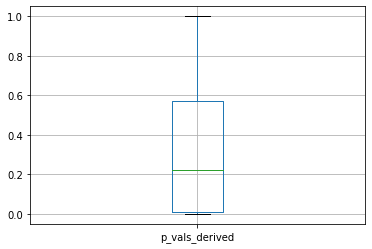

In [87]:
big_kahuna[big_kahuna['p_vals_derived'] != -1].boxplot(column=['p_vals_derived'])

In [88]:
# Make our own stats rows
base = big_kahuna[['study_id', 'measure', 'title', 'measure_param', 'p_vals_derived']]
base['groups'] = pd.Series([[x[0], x[1]] for x in zip(big_kahuna['drug_group_id'].tolist(), big_kahuna['control_group_id'].tolist())])
base['fromStudy'] = pd.Series([False for x in range(len(big_kahuna['drug_group_id'].tolist()))])
base['group_titles'] = pd.Series([dict([x[0], x[1]]) for x in zip(zip(big_kahuna['drug_group_id'].tolist(), big_kahuna['title_y'].tolist()), zip(big_kahuna['control_group_id'].tolist(), big_kahuna['control_title'].tolist()))])
base['method'] = pd.Series(['t-test' for x in range(len(big_kahuna['drug_group_id'].tolist()))])
new_analytics = base.rename(columns={
    'title': 'description',
    'measure_param': 'param_type',
    'p_vals_derived': 'pval'
})
new_analytics

/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:

,study_id,measure,description,param_type,pval,groups,fromStudy,group_titles,method
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,NA,NA,-1.000000,"[OG000, OG001]",False,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",t-test
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,NA,NA,-1.000000,"[OG000, OG001]",False,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",t-test
2,NCT02359110,NRS (Numerical Rating Scale),Hour 2,Least Squares Mean,0.884442,"[OG000, OG001]",False,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",t-test
3,NCT02359110,NRS (Numerical Rating Scale),Hour 4,Least Squares Mean,0.904472,"[OG000, OG001]",False,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",t-test
4,NCT02359110,NRS (Numerical Rating Scale),Hour 6,Least Squares Mean,0.588966,"[OG000, OG001]",False,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",t-test
...,...,...,...,...,...,...,...,...,...
957,NCT01868425,Intraoperative Medication Use: Ketorolac and L...,Intraoperative Lidocaine,Mean,0.346299,"[OG000, OG001]",False,"{'OG000': 'Multimodal:Acetaminophen, Gabapenti...",t-test
958,NCT01868425,Intraoperative Medication Use: Fentanyl,NA,Mean,0.830051,"[OG000, OG001]",False,"{'OG000': 'Multimodal:Acetaminophen, Gabapenti...",t-test
959,NCT01868425,Number of Participants With Complications From...,NA,Count of Participants,-1.000000,"[OG000, OG001]",False,"{'OG000': 'Multimodal:Acetaminophen, Gabapenti...",t-test
960,NCT01868425,Time to Discharge,Discharge from Recovery Room,Mean,0.336595,"[OG000, OG001]",False,"{'OG000': 'Multimodal:Acetaminophen, Gabapenti...",t-test


In [89]:
total_analytics = pd.concat([analytics, new_analytics])
# We need a way to figure out the control and intervention groups of the analytics table - merge with the measures??
# That can't be done because the titles are different - I think we need to look at the group titles and use the same 
# function that labels the groups
def get_nested_groups(nested, func):
    for val in nested.values():
        if func(val):
            return val
    return 'NA'
        
total_analytics['intervention_title'] = total_analytics['group_titles'].apply(lambda x: get_nested_groups(x, find_drug_groups))
total_analytics['control_title'] = total_analytics['group_titles'].apply(lambda x: get_nested_groups(x, find_placebo_groups))
total_analytics.head()


,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo
4,NCT02359110,VAS (Visual Analog Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.52,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo


#### Aggregates 
- Look at the p-vals from all the primary measures 
- Make sure the measure p-values make sense
- Look at the ranges for all the studies
- Break it down by condition 

In [90]:
measures.head()

,study_id,measure,type,description,dispersion_param,measure_param,units
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA
2,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale
3,NCT02359110,VAS (Visual Analog Scale),Secondary,The VAS is scored using a horizontal line 100m...,95% Confidence Interval,Least Squares Mean,units on a scale
4,NCT02359110,Total Morphine Consumption,Secondary,NA,Standard Deviation,Mean,mg


In [92]:
# New table for the aggregates - needs a few things about the measure&study
# type and condition
# This is admitedly bad because it assumes that since the study has pain in a condition, that the 
# measure also involves pain which is wrong
agg = total_analytics.merge(
    measures[['study_id', 'measure', 'type', 'description']], 'left', ['study_id', 'measure']).merge(
    studies_df[['study_id', 'mesh_terms', 'conditions']], 'left', ['study_id']).rename(columns={
    'description_y': 'measure_description', 'description_x': 'description'})
agg['pval'] = agg['pval'].apply(str) # String for regex parsing
agg.head()

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,mesh_terms,conditions
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,"[Pain, Postoperative]",[Postoperative Pain]
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,"[Pain, Postoperative]",[Postoperative Pain]
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,"[Pain, Postoperative]",[Postoperative Pain]
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,"[Pain, Postoperative]",[Postoperative Pain]
4,NCT02359110,VAS (Visual Analog Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.52,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Secondary,The VAS is scored using a horizontal line 100m...,"[Pain, Postoperative]",[Postoperative Pain]


In [93]:
import re

# This is bad - need to make a distinction between < and > - don't know what to tag '>'
def get_pval_floats(pval):
    try:
        match_range = re.search(r"[<=]", pval)
        greater_match = re.search(r"[>]", pval)
        
        if match_range:
            return float(pval[match_range.start()+1 : len(pval)])
        
        if greater_match:
            return 1
        
        return float(pval)
    except ValueError as e:
        return -2
    return -2

agg['pval_float'] = agg['pval'].apply(get_pval_floats)
# Drop this fucking measure 
agg = agg.drop(agg[agg['pval_float'] > 1].index)
agg['pval_float'].value_counts() # Definitely needs work - still problems with repeats

-1.000000    346
 0.000100    100
-2.000000     53
 1.000000     48
 0.001000     28
            ... 
 0.258373      1
 0.903400      1
 0.172000      1
 0.367500      1
 0.024691      1
Name: pval_float, Length: 1793, dtype: int64

In [94]:
agg.head()

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,mesh_terms,conditions,pval_float
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,"[Pain, Postoperative]",[Postoperative Pain],0.89
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,"[Pain, Postoperative]",[Postoperative Pain],0.94
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,"[Pain, Postoperative]",[Postoperative Pain],0.64
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,"[Pain, Postoperative]",[Postoperative Pain],0.59
4,NCT02359110,VAS (Visual Analog Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.52,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Secondary,The VAS is scored using a horizontal line 100m...,"[Pain, Postoperative]",[Postoperative Pain],0.52


In [95]:
agg_minus_dupes = agg.drop_duplicates(['study_id', 'measure', 'description', 'method', 'param_type', 'fromStudy', 'pval', 'type'])
agg_minus_dupes['pval_float'].value_counts()

-1.000000    170
 1.000000     45
 0.000100     44
 0.001000     28
-2.000000     21
            ... 
 0.903400      1
 0.172000      1
 0.367500      1
 0.136040      1
 0.024691      1
Name: pval_float, Length: 1793, dtype: int64

<AxesSubplot:>

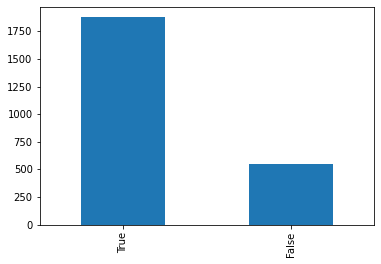

In [96]:
agg_minus_dupes['fromStudy'].value_counts().plot.bar()

<AxesSubplot:>

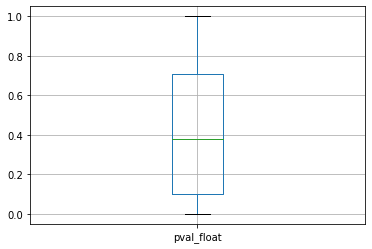

In [97]:
agg_minus_dupes[agg_minus_dupes['pval_float'] > 0].boxplot(column=['pval_float']) # This is starting to look good 




## Grouping
- Assuming our results are good enough - let's start doing some meta-analysis

### Measurements for Conditions
In order to accurately parse the secondary measurements of all the studies, we need to get a dictionary going 
of all the measurements used to assess treatments of them

Once this is done we will create a model to measure the likeliehood of a measure being one of the measures in the list

In [60]:
measurements = agg_minus_dupes[['study_id', 'measure', 'type', 'conditions']]
measurements = measurements.drop_duplicates(['study_id', 'measure', 'type'])

<AxesSubplot:>

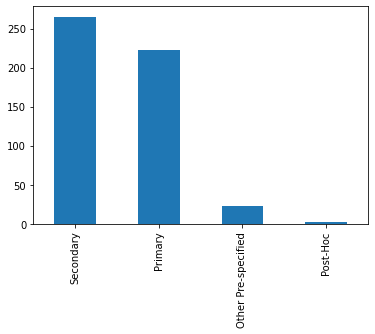

In [61]:
measurements['type'].value_counts().plot.bar()

<AxesSubplot:>

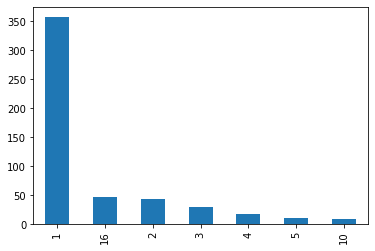

In [62]:
# Of course many studies have different types of conditions so what should we do there
# Let's do the ones with one condition automatically and then label the rest
measurements['conditions'].apply(len).value_counts().plot.bar()

In [63]:
studies_df.head()

,study_id,name,drug,conditions,verified_date,responsible_party,type,description,interventions,purpose,intervention_type
0,NCT01675960,"A Phase II, Randomized, Placebo-controlled, Do...",gabapentin,"[Neurologically Impaired, Irritable Mood, Sign...",July 2019,{'ResponsiblePartyType': 'Sponsor'},Interventional,"This is a randomized, placebo-controlled, cros...",[Gabapentin],Treatment,Crossover Assignment
1,NCT02359110,Administration of Pre-Operative Gabapentin to ...,gabapentin,[Postoperative Pain],March 2018,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,The purpose of this study is to prospectively ...,[Gabapentin],Treatment,Parallel Assignment
2,NCT01977937,Pain Control in Pediatric Posterior Spine Fusi...,gabapentin,"[Pain, Postoperative]",May 2019,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,Patients aged 10-19 years with idiopathic scol...,[Gabapentin],Treatment,Parallel Assignment
3,NCT03334903,Gabapentin Regimens and Their Effects on Opioi...,gabapentin,"[Knee Osteoarthritis, Knee Pain Chronic, Opioi...",February 2021,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,The purpose of this study is to determine the ...,[Gabapentin],Treatment,Parallel Assignment
4,NCT02052414,"Open Labeled, Non-randomized, Study of Efficac...",gabapentin,[Fibromyalgia],September 2016,{'ResponsiblePartyType': 'Sponsor'},Interventional,Subject must carry a diagnosis of fibromyalgia...,[Gabapentin],Treatment,Single Group Assignment


In [64]:
studies_df[['study_id', 'name', 'description']].head()

,study_id,name,description
0,NCT01675960,"A Phase II, Randomized, Placebo-controlled, Do...","This is a randomized, placebo-controlled, cros..."
1,NCT02359110,Administration of Pre-Operative Gabapentin to ...,The purpose of this study is to prospectively ...
2,NCT01977937,Pain Control in Pediatric Posterior Spine Fusi...,Patients aged 10-19 years with idiopathic scol...
3,NCT03334903,Gabapentin Regimens and Their Effects on Opioi...,The purpose of this study is to determine the ...
4,NCT02052414,"Open Labeled, Non-randomized, Study of Efficac...",Subject must carry a diagnosis of fibromyalgia...


In [65]:
measurements.head()

,study_id,measure,type,conditions
0,NCT02359110,NRS (Numerical Rating Scale),Primary,[Postoperative Pain]
4,NCT02359110,VAS (Visual Analog Scale),Secondary,[Postoperative Pain]
6,NCT02359110,Total Morphine Consumption,Secondary,[Postoperative Pain]
7,NCT01977937,Difference in Pain Control When Adding Gabapen...,Primary,"[Pain, Postoperative]"
8,NCT01977937,Opiate Usage in the Gabapentin Group Versus Co...,Secondary,"[Pain, Postoperative]"


In [66]:
single_measurements = measurements[measurements['conditions'].apply(len) == 1]
single_measurements['single_condition'] = single_measurements['conditions'].apply(lambda x: x[0])
single_measurements = single_measurements.merge(studies_df[['study_id', 'name', 'description']], 'left', 'study_id')
single_measurements.head()

/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,study_id,measure,type,conditions,single_condition,name,description
0,NCT02359110,NRS (Numerical Rating Scale),Primary,[Postoperative Pain],Postoperative Pain,Administration of Pre-Operative Gabapentin to ...,The purpose of this study is to prospectively ...
1,NCT02359110,VAS (Visual Analog Scale),Secondary,[Postoperative Pain],Postoperative Pain,Administration of Pre-Operative Gabapentin to ...,The purpose of this study is to prospectively ...
2,NCT02359110,Total Morphine Consumption,Secondary,[Postoperative Pain],Postoperative Pain,Administration of Pre-Operative Gabapentin to ...,The purpose of this study is to prospectively ...
3,NCT01977937,Difference in Pain Control When Adding Gabapen...,Primary,"[Pain, Postoperative]","Pain, Postoperative",Pain Control in Pediatric Posterior Spine Fusi...,Patients aged 10-19 years with idiopathic scol...
4,NCT01977937,Opiate Usage in the Gabapentin Group Versus Co...,Secondary,"[Pain, Postoperative]","Pain, Postoperative",Pain Control in Pediatric Posterior Spine Fusi...,Patients aged 10-19 years with idiopathic scol...


In [81]:
# Make a small dataframe for labeling
single_measurements.to_csv('single_measurements.csv')

In [43]:
pain_agg = agg_minus_dupes[(agg_minus_dupes['is_pain']) & (agg_minus_dupes['pval_float'] > 0) & (agg_minus_dupes['type'] == 'Primary')]
pain_agg

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float,is_pain
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.890000,True
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.940000,True
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.640000,True
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.590000,True
7,NCT01977937,Difference in Pain Control When Adding Gabapen...,"[OG000, OG001]",D'Agostino & Pearson normality test was used t...,"t-test, 2 sided",NA,True,0.07,"{'OG000': 'Gabapentin', 'OG001': 'Simple Syrup'}",Gabapentin,NA,Primary,Patients will rate their pain using the Visual...,"[Pain, Postoperative]",0.070000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855,NCT01506453,Daily Total Dose of Oral Morphine (mg/kg/Day).,"[OG000, OG001]",Day 16,t-test,Mean,False,0.6014976138086221,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The response to therapy will be measured by pa...,"[Acute Lymphoblastic Leukemia, Neuropathy, Neu...",0.601498,True
2856,NCT01506453,Daily Total Dose of Oral Morphine (mg/kg/Day).,"[OG000, OG001]",Day 17,t-test,Mean,False,0.527201298565683,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The response to therapy will be measured by pa...,"[Acute Lymphoblastic Leukemia, Neuropathy, Neu...",0.527201,True
2858,NCT01506453,Daily Total Dose of Oral Morphine (mg/kg/Day).,"[OG000, OG001]",Day 19,t-test,Mean,False,0.3242055546647684,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The response to therapy will be measured by pa...,"[Acute Lymphoblastic Leukemia, Neuropathy, Neu...",0.324206,True
2902,NCT01067144,Time to Pain Resolution,"[OG001, OG000]",NA,t-test,Median,False,0.4075835931290681,"{'OG001': 'Gabapentin', 'OG000': 'Control'}",Gabapentin,Control,Primary,Time to pain resolution was defined as 5 conse...,"[Pain, Breast Cancer, Lung Cancer]",0.407584,True


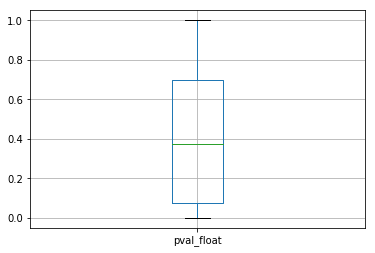

In [44]:
pain_agg.boxplot(column=['pval_float'])

# Looks like this hasn't changed from the aggregates 

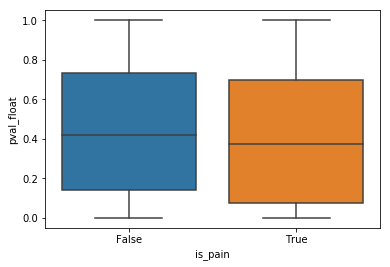

In [45]:
boxie = agg_minus_dupes[(agg_minus_dupes['type'] == 'Primary') & (agg_minus_dupes['pval_float'] > 0)]
sns.boxplot(x='is_pain', y='pval_float', data=boxie)

In [46]:
# A few different things we could look at with these values
# Start looking at what measures are relevant to what condition - this opens up secondary measures 
# Look at the difference between derived and absolute - maybe flag those studies
# Look at the 'purity' of a measure for a drug - see if that measure is only using that drug or something else 
# Start looking at ways to aggregate the doses for analysis
# Start looking at ways to cluster the conditions for similarities
# Start parsing out the side effects 

# I think we need to differentiate between interventions to get purity of a test

In [47]:
# We need the measure description, and both of the groups descriptions

int_aggs = agg_minus_dupes.merge(studies_df[['study_id', 'interventions']], 'left', ['study_id']).rename(columns={
    'interventions':'study_interventions'})
int_aggs.head()

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float,is_pain,study_interventions
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.89,True,[Gabapentin]
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.94,True,[Gabapentin]
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.64,True,[Gabapentin]
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.59,True,[Gabapentin]
4,NCT02359110,VAS (Visual Analog Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.52,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Secondary,The VAS is scored using a horizontal line 100m...,[Postoperative Pain],0.52,True,[Gabapentin]


In [48]:
# Get number of interventions used 

int_aggs['ints_used'] = int_aggs.apply(lambda x: list(filter(lambda y: y.lower() in x.intervention_title.lower(), x.study_interventions)), axis=1)
int_aggs['no_ints_used'] = int_aggs['ints_used'].apply(len)
int_aggs.head()

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float,is_pain,study_interventions,ints_used,no_ints_used
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.89,True,[Gabapentin],[Gabapentin],1
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.94,True,[Gabapentin],[Gabapentin],1
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.64,True,[Gabapentin],[Gabapentin],1
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Primary,The NRS is a numerical scale ranging from 0-10...,[Postoperative Pain],0.59,True,[Gabapentin],[Gabapentin],1
4,NCT02359110,VAS (Visual Analog Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.52,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",Gabapentin,Placebo,Secondary,The VAS is scored using a horizontal line 100m...,[Postoperative Pain],0.52,True,[Gabapentin],[Gabapentin],1


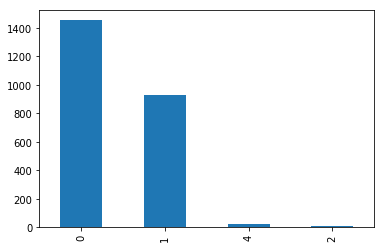

In [49]:
int_aggs['no_ints_used'].value_counts().plot.bar()

In [50]:
int_aggs[int_aggs['no_ints_used'] == 0]

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles,intervention_title,control_title,type,measure_description,conditions,pval_float,is_pain,study_interventions,ints_used,no_ints_used
14,NCT00475904,Change in Pain Scores Comparing NP-1 Cream vs....,"[OG000, OG002]","In the initial analysis, the efficacy of the t...",ANOVA,Mean Difference (Final Values),True,0.0441,"{'OG000': 'Amitriptyline 4% Ketamine 2% Cream,...",NA,"Amitriptyline 4% Ketamine 2% Cream, Placebo Ca...",Primary,Difference in pain scores between NP-1 cream v...,"[Post Herpetic Neuralgia, PHN, Neuropathy, Ner...",0.044100,True,[Gabapentin],[],0
24,NCT01623271,Visual Analog Scale (VAS) at Visit 3,[OG000],NA,"t-test, 2 sided",NA,True,>0.05,{'OG000': 'CRPS I Pain Subjects'},NA,NA,Primary,Subjects rated their pain using the VAS at vis...,[Complex Regional Pain Syndrome I (CRPS I)],1.000000,True,[Gabapentin],[],0
47,NCT00755417,Change From Baseline in Average Daily Frequenc...,"[OG000, OG002]",Null hypothesis was that there were no treatme...,ANCOVA,Mean Difference (Final Values),True,0.0117,"{'OG000': 'G-ER 1200 mg', 'OG002': 'Sugar Pill'}",NA,NA,Primary,Change from baseline in average daily frequenc...,[Hot Flashes],0.011700,False,[Gabapentin],[],0
48,NCT00755417,Change From Baseline in Average Daily Frequenc...,"[OG001, OG002]",Null hypothesis was that there were no treatme...,ANCOVA,Mean Difference (Final Values),True,<0.0001,"{'OG001': 'G-ER 1800 mg', 'OG002': 'Sugar Pill'}",NA,NA,Primary,Change from baseline in average daily frequenc...,[Hot Flashes],0.000100,False,[Gabapentin],[],0
49,NCT00755417,Change From Baseline in Average Daily Frequenc...,"[OG000, OG002]",Null hypothesis was that there were no treatme...,ANCOVA,Mean Difference (Final Values),True,0.1830,"{'OG000': 'G-ER 1200 mg', 'OG002': 'Sugar Pill'}",NA,NA,Primary,Change from baseline in average daily frequenc...,[Hot Flashes],0.183000,False,[Gabapentin],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,NCT01524796,Change From Baseline In Least Pain Level At Mo...,[OG000],NA,Wilcoxon signed-rank test,NA,True,<0.001,{'OG000': 'Pregabalin'},NA,NA,Primary,Pain was assessed on an 11-point NRS where a s...,[Peripheral Neuropathic Pain],0.001000,True,[Pregabalin],[],0
1873,NCT00667342,Mean Ktrans,[OG000],NA,Logistic Regression,NA,True,0.0863,{'OG000': 'A: Localized Resectable Disease'},NA,NA,Secondary,The volume transfer constant (Ktrans) was used...,"[Osteosarcoma, Malignant Fibrous Histiocytoma ...",0.086300,False,"[Bevacizumab, Cisplatin, Doxorubicin, Methotre...",[],0
1874,NCT00667342,Mean Vp,[OG000],NA,Logistic Regression,NA,True,0.0573,{'OG000': 'A: Localized Resectable Disease'},NA,NA,Secondary,The fractional blood plasma volume (Vp) was us...,"[Osteosarcoma, Malignant Fibrous Histiocytoma ...",0.057300,False,"[Bevacizumab, Cisplatin, Doxorubicin, Methotre...",[],0
1875,NCT00667342,Mean Ve,[OG000],NA,Logistic Regression,NA,True,0.0863,{'OG000': 'A: Localized Resectable Disease'},NA,NA,Secondary,The fractional volume of extravascular extrace...,"[Osteosarcoma, Malignant Fibrous Histiocytoma ...",0.086300,False,"[Bevacizumab, Cisplatin, Doxorubicin, Methotre...",[],0


Currently looking at about a 20% hit rate for analytics coming from the studies themsevles
This is not good at all considering these are generally assumed to be more accurate though 
they do measure more things than just one drug so high attrition is to be expected

- Note: Over half of those are coming from two studies with no interventions at all so it's not as bas as it seems

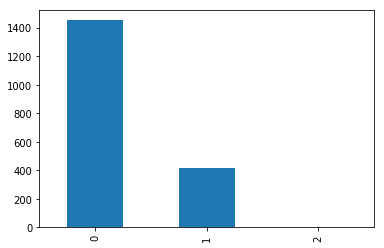

In [51]:
int_aggs[int_aggs['fromStudy']]['no_ints_used'].value_counts().plot.bar()

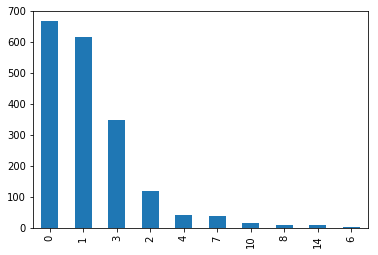

In [52]:
int_aggs[int_aggs['fromStudy']]['study_interventions'].apply(len).value_counts().plot.bar()

# How can a study have 0 interventions???

In [53]:
int_aggs[int_aggs['study_interventions'].apply(len) == 0]['study_id'].value_counts()

NCT03975790    665
NCT00404248      3
Name: study_id, dtype: int64

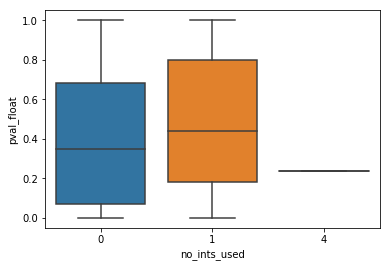

In [54]:
# Let's redo the pain stuff with boxplots
pain_agg = int_aggs[int_aggs['is_pain'] & (int_aggs['pval_float'] > 0) & (int_aggs['type'] == 'Primary')]
sns.boxplot(x='no_ints_used', y='pval_float', data=pain_agg)

Let's see if we can get some decent results this way - only using primaries

- Secondaries should be labeled for this kind of thing to, but our false positive rate is low which is what matters
- Still need to deal with that greater than issue


In [55]:
# Need to break off a few conditions - let's manually group them for now - just take the first one
studies_df['conditions'].apply(lambda x: x[0]).value_counts()[0:10]

Restless Legs Syndrome                     7
Postoperative Pain                         6
Pain                                       5
Alcohol Dependence                         4
Epilepsies, Partial                        4
Hot Flashes                                3
Healthy                                    3
Post Herpetic Neuralgia                    2
Brain and Central Nervous System Tumors    2
Benzodiazepine Dependence                  2
Name: conditions, dtype: int64

In [56]:
int_aggs['conditions'].apply(lambda x: x[0]).value_counts()

Rheumatoid Arthritis                         665
Pain, Neuropathic                            364
Diabetic Neuropathy, Painful                 326
Healthy                                      156
Renal Pelvis Cancer                           80
                                            ... 
Benzodiazepine Dependence                      1
Vulvar Pain Symptoms                           1
Complex Regional Pain Syndrome I (CRPS I)      1
Opioid-Induced Hyperalgesia                    1
Diabetic Neuropathic Pain                      1
Name: conditions, Length: 64, dtype: int64

In [51]:
int_aggs['study_id'].value_counts()

NCT03975790    665
NCT01236053    364
NCT00385671    326
NCT03179345    120
NCT01138124     80
              ... 
NCT01893632      1
NCT00390013      1
NCT01332318      1
NCT01632215      1
NCT01623271      1
Name: study_id, Length: 86, dtype: int64

## Side Affects
Take a look at the adverse affects from each study - this is where drug purity comes in though

Should we just sum up all the adverse affects or only those with the drug in them

#### Data Model
- Need to make the tables first 

In [52]:
groups.head()

,name,study_id,id,description,participants
0,"Gabapentin, Then Placebo",NCT01675960,BG000,Participants first receive gabapentin 3 times ...,2
1,"Placebo, Then Gabapentin",NCT01675960,BG001,Participants first receive placebo 3 times per...,0
2,Total,NCT01675960,BG002,Total of all reporting groups,2
3,Gabapentin,NCT02359110,BG000,Patients will receive Gabapentin 300mg tab les...,55
4,Placebo,NCT02359110,BG001,Patients will receive Methylcellulose based pl...,54


In [103]:
# We need to add the event groups to the groups table??
import re
def parse_participant_string(participants):
    return int(re.sub('[^0-9]', '', str(participants)))
    
    
def add_effects_groups(studies):
    df = {
        'study_id': [],
        'id': [],
        'name': [],
        'description': [],
        'participants': []
    }
    for i, study in enumerate(studies):
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        adverse_module = study['Study']['ResultsSection'].get('AdverseEventsModule', {}) #Small risk here
        for group in adverse_module.get('EventGroupList', {'EventGroup': []})['EventGroup']:
            df['study_id'].append(study_id)
            df['id'].append(group.get('EventGroupId', 'NA'))
            df['name'].append(group.get('EventGroupTitle', 'NA'))
            df['description'].append(group.get('EventGroupDescription', 'NA'))
            df['participants'].append(parse_participant_string(group.get('EventGroupOtherNumAtRisk', 0) or group.get('EventGroupDeathsNumAtRisk', 0) or group.get('EventGroupSeriousNumAtRisk', 0)))
    
    return df

total_groups = pd.concat([groups, pd.DataFrame.from_dict(add_effects_groups(studies))])
total_groups.head()

,name,study_id,id,description,participants
0,"Gabapentin, Then Placebo",NCT01675960,BG000,Participants first receive gabapentin 3 times ...,2
1,"Placebo, Then Gabapentin",NCT01675960,BG001,Participants first receive placebo 3 times per...,0
2,Total,NCT01675960,BG002,Total of all reporting groups,2
3,Gabapentin,NCT02359110,BG000,Patients will receive Gabapentin 300mg tab les...,55
4,Placebo,NCT02359110,BG001,Patients will receive Methylcellulose based pl...,54


In [94]:
def create_effects_table(studies, drug):
    df = {
        'drug': [],
        'study_id': [],
        'group_id': [],
        'effect_name': [],
        'type': [], #Serious or other
        'organ_system': [],
        'assesment': [],
        'no_effected': [],
        'collection_threshold': []
    }
    for i, study in enumerate(studies):
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        adverse_module = study['Study']['ResultsSection'].get('AdverseEventsModule', {}) #Small risk here
        for event in adverse_module.get('OtherEventList', {'OtherEvent': []})['OtherEvent']:
            for stat in event.get('OtherEventStatsList', {'OtherEventStats': []})['OtherEventStats']:
                df['drug'].append(drug)
                df['study_id'].append(study_id)
                df['group_id'].append(stat.get('OtherEventStatsGroupId', 'NA'))
                df['effect_name'].append(event.get('OtherEventTerm', 'NA'))
                df['type'].append('other')
                df['organ_system'].append(event.get('OtherEventOrganSystem', 'NA'))
                df['assesment'].append(event.get('OtherEventAssessmentType', 'NA'))
                df['no_effected'].append(float(stat.get('OtherEventStatsNumAffected', 0)) or float(stat.get('OtherEventStatsNumEvents', 0)))
                df['collection_threshold'].append(float(adverse_module.get('EventsFrequencyThreshold', -1)))
    return df

effects = pd.DataFrame.from_dict(create_effects_table(studies, EXAMPLE_DRUG))
effects       

,drug,study_id,group_id,effect_name,type,organ_system,assesment,no_effected,collection_threshold
0,gabapentin,NCT01675960,EG000,Increased sleepiness,other,General disorders,Non-systematic Assessment,1.0,0.0
1,gabapentin,NCT01675960,EG001,Increased sleepiness,other,General disorders,Non-systematic Assessment,0.0,0.0
2,gabapentin,NCT01977937,EG000,Emesis,other,Gastrointestinal disorders,Systematic Assessment,1.0,0.0
3,gabapentin,NCT01977937,EG001,Emesis,other,Gastrointestinal disorders,Systematic Assessment,0.0,0.0
4,gabapentin,NCT02052414,EG000,Extremity swelling,other,Metabolism and nutrition disorders,Systematic Assessment,2.0,0.0
...,...,...,...,...,...,...,...,...,...
3075,gabapentin,NCT00667342,EG001,"Pain, lip",other,General disorders,Non-systematic Assessment,1.0,5.0
3076,gabapentin,NCT00667342,EG000,"Infection (ANC <1.0 x 10e9/L, fever >38.5 degr...",other,Infections and infestations,Non-systematic Assessment,0.0,5.0
3077,gabapentin,NCT00667342,EG001,"Infection (ANC <1.0 x 10e9/L, fever >38.5 degr...",other,Infections and infestations,Non-systematic Assessment,2.0,5.0
3078,gabapentin,NCT00667342,EG000,Infection with normal ANC or Grade 1 or 2 neut...,other,Infections and infestations,Non-systematic Assessment,0.0,5.0


#### Explore Effects
Let's take a look into this brand new world just discovered

In [55]:
# The top few are expected for this drug

effects['effect_name'].value_counts()

Dizziness            113
Headache             101
Nausea               100
Somnolence            90
Fatigue               74
                    ... 
Rhinitis allergic      1
Hot flashes            1
Coughing               1
Gas                    1
Mild rash              1
Name: effect_name, Length: 678, dtype: int64

#### Compare to Controls
Let's label which effects came from the drug versus the control to get a good idea

In [56]:
working_effects = effects.merge(total_groups.rename(columns={'id': 'group_id'}), 'left', ['study_id', 'group_id'])
working_effects['is_control'] = working_effects['name'].apply(find_placebo_groups)
working_effects['is_intervention'] = working_effects['name'].apply(find_drug_groups)
working_effects

,drug,study_id,group_id,effect_name,type,organ_system,assesment,no_effected,collection_threshold,name,description,participants,is_control,is_intervention
0,gabapentin,NCT01675960,EG000,Increased sleepiness,other,General disorders,Non-systematic Assessment,1.0,0.0,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,2,False,True
1,gabapentin,NCT01675960,EG001,Increased sleepiness,other,General disorders,Non-systematic Assessment,0.0,0.0,Placebo,Glycerin based clear solution that is flavored...,2,True,False
2,gabapentin,NCT01977937,EG000,Emesis,other,Gastrointestinal disorders,Systematic Assessment,1.0,0.0,Gabapentin,Gabapentin 15 milligrams per kilogram will be ...,24,False,True
3,gabapentin,NCT01977937,EG001,Emesis,other,Gastrointestinal disorders,Systematic Assessment,0.0,0.0,Simple Syrup,Simple syrup compounded by the Oregon Health a...,26,False,False
4,gabapentin,NCT02052414,EG000,Extremity swelling,other,Metabolism and nutrition disorders,Systematic Assessment,2.0,0.0,Gralise (Gabapentin ER),An Open label trial with Gralise. All subjects...,31,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075,gabapentin,NCT00667342,EG001,"Pain, lip",other,General disorders,Non-systematic Assessment,1.0,5.0,C: Metastatic Tumors,Stratum C participants had metastatic tumors.,11,False,False
3076,gabapentin,NCT00667342,EG000,"Infection (ANC <1.0 x 10e9/L, fever >38.5 degr...",other,Infections and infestations,Non-systematic Assessment,0.0,5.0,A: Localized Resectable Disease,Stratum A participants had primary tumors pote...,31,False,False
3077,gabapentin,NCT00667342,EG001,"Infection (ANC <1.0 x 10e9/L, fever >38.5 degr...",other,Infections and infestations,Non-systematic Assessment,2.0,5.0,C: Metastatic Tumors,Stratum C participants had metastatic tumors.,11,False,False
3078,gabapentin,NCT00667342,EG000,Infection with normal ANC or Grade 1 or 2 neut...,other,Infections and infestations,Non-systematic Assessment,0.0,5.0,A: Localized Resectable Disease,Stratum A participants had primary tumors pote...,31,False,False


In [82]:
working_effects[working_effects['effect_name'].apply(lambda x: 'somnolence' in x.lower()) & working_effects['is_intervention']]

,drug,study_id,group_id,effect_name,type,organ_system,assesment,no_effected,collection_threshold,name,description,participants,is_control,is_intervention
125,gabapentin,NCT01141049,EG000,somnolence,other,General disorders,Systematic Assessment,2.0,5.0,Gabapentin,Gabapentin will be titrated over a 7-day perio...,19,False,True
153,gabapentin,NCT00974376,EG000,Somnolence,other,Nervous system disorders,Systematic Assessment,7.0,5.0,Gabapentin 1200mg/Day,1200mg/day of gabapentin given in conjunction ...,75,False,True
196,gabapentin,NCT00603473,EG000,Somnolence,other,Nervous system disorders,Systematic Assessment,35.0,3.0,Gabapentin,The dosage of oral solution for subjects aged ...,89,False,True
217,gabapentin,NCT02252536,EG001,Somnolence,other,Nervous system disorders,Systematic Assessment,30.0,5.0,Gabapentin Enacarbil,600 mg Gabapentin Enacarbil (Horizant)\n\ngaba...,170,False,True
276,gabapentin,NCT02725710,EG001,Somnolence,other,General disorders,Non-systematic Assessment,41.0,0.0,Group 2: Gabapentin,Usual perioperative pain management protocol P...,47,False,True
290,gabapentin,NCT01301001,EG001,Somnolence,other,Nervous system disorders,Systematic Assessment,7.0,5.0,Gabapentin,2 capsules (1200 mg) am and 3 capsules (1800) ...,89,False,True
346,gabapentin,NCT03334721,EG000,Somnolence,other,Nervous system disorders,Systematic Assessment,1.0,0.0,Gabapentin,Each 1-week condition will consist of an in-pe...,23,False,True
401,gabapentin,NCT00620555,EG000,Somnolence,other,Nervous system disorders,Systematic Assessment,10.0,5.0,Gabapentin,Pediatric participants received gabapentin thr...,65,False,True
406,gabapentin,NCT03053427,EG001,Somnolence neonatal,other,Nervous system disorders,Systematic Assessment,25.0,5.0,Gabapentin Enacarbil,Gabapentin enacarbil was administered orally o...,189,False,True
461,gabapentin,NCT00634543,EG001,Somnolence,other,Nervous system disorders,Non-systematic Assessment,5.0,2.0,Gabapentin,Participants received gabapentin 300 mg once d...,80,False,True


In [57]:
int_sums = {}
def count_effects(effect_name, no_affected, ledger):
    if effect_name not in ledger:
        ledger[effect_name] = 0
    ledger[effect_name] += no_affected

intervention_effects = working_effects[working_effects['is_intervention']]

intervention_effects.apply(lambda x: count_effects(x.effect_name, x.no_effected, int_sums), axis=1)
int_effect_sums = pd.Series(int_sums).sort_values(ascending=False)
int_effect_sums

Dizziness              392.0
Somnolence             382.0
Headache               276.0
Nausea                 235.0
Dry mouth              207.0
                       ...  
Pulmonary effusion       0.0
Pulmonary edema          0.0
Pharyngeal leak          0.0
Oxygen desaturation      0.0
Hypoparathyroidism       0.0
Length: 435, dtype: float64

In [58]:
# Now the controls 
cont_sums = {}
working_effects[working_effects['is_control']].apply(lambda x: count_effects(x.effect_name, x.no_effected, cont_sums), axis=1)
cont_effect_sums = pd.Series(cont_sums).sort_values(ascending=False)
cont_effect_sums

Headache                          237.0
Nausea                            221.0
Dry mouth                         196.0
Dizziness                         191.0
Constipation                      176.0
                                  ...  
Parasthesia (right foot)            0.0
Oropharyngeal bleeding              0.0
Oral wound dehiscence               0.0
Myasthenia gravis exacerbation      0.0
Increased sleepiness                0.0
Length: 345, dtype: float64

<AxesSubplot:>

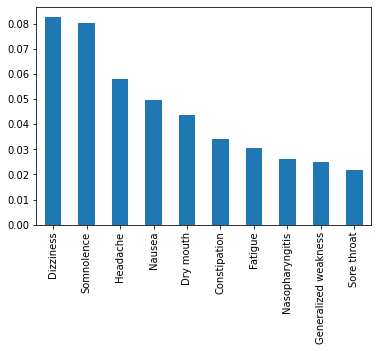

In [59]:
# Get the percentages 
total_at_risk = working_effects[working_effects['is_intervention']].drop_duplicates(['study_id'])['participants'].sum()
percent_effects = {k: (v/total_at_risk) for (k,v) in int_sums.items()}
pd.Series(percent_effects).sort_values(ascending=False)[0:10].plot.bar()


### Clustering 
There are a lot of similar conditions and side effects that should be considered as one

Not expercting a full blown system or model as might be reuqired, but maybe some basic edit distance clustering 
would help

We could also take a look wordnet to find synonyms here - might be better than a medical dictionary, though wordnet might be quite large 

Perhaps removing the adjectives in the conditions would help as well - jsut get the noun

In [60]:
# Edit distance implementation: https://stackoverflow.com/questions/2460177/edit-distance-in-python

def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [61]:
# Git a list of all the conditions 
conditions = pd.Series([c for cs in studies_df['conditions'].tolist() for c in cs ])


In [62]:
# Cluster by distance to see what similar means 
# We will try: heirarchical, affinity, and maybe some graph based 
# First heirarchical 

# Edit distance is a terrible meausre since we're clustering by medical terms 
from sklearn.cluster import AffinityPropagation

words = conditions.tolist()
words = np.asarray(words) #So that indexing with a list will work
def affinity_cluster(words, distance):
    lev_similarity = -1*np.array([[distance(w1,w2) for w1 in words] for w2 in words])

    affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
    affprop.fit(lev_similarity)
    for cluster_id in np.unique(affprop.labels_):
        exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
        cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
        cluster_str = ", ".join(cluster)
        print(" - *%s:* %s" % (exemplar, cluster_str))
        
affinity_cluster(words, levenshteinDistance) # Didn't fucking work at all!

 - *Signs and Symptoms, Digestive:* Signs and Symptoms, Digestive
 - *Pain, Postoperative:* Pain, Intractable, Pain, Postoperative
 - *Benzodiazepine Dependence:* Benzodiazepine Dependence
 - *Opioid Use:* Blood Pressure, Obesity, Morbid, Opioid Use, Tobacco Use
 - *Hospital Length of Stay:* Hospital Length of Stay
 - *Alcohol Dependence:* Abortion, Induced, Alcohol Dependence, Cannabis Dependence, Cocaine Dependence, Opioid Dependence, Vasomotor Disturbance
 - *Aneurysmal Subarachnoid Hemorrhage:* Aneurysmal Subarachnoid Hemorrhage
 - *Neuropathy:* Burn Injury, Facial Neuropathy, Menopause, Neuropathy, Pain, Neuropathic, Polyneuropathies, Radiculopathy
 - *Spontaneous Abortion:* Cisplatin Adverse Reaction, Conscious Sedation, Opioid Detoxification, Other Abortion, Spontaneous Abortion
 - *Vulvodynia (Chronic Vulvar Pain):* Vulvodynia (Chronic Vulvar Pain)
 - *Postoperative Pain:* Posterior Spine Surgery, Postoperative Delirium, Postoperative Nausea and Vomiting, Postoperative Pain
 - 

/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


<AxesSubplot:>

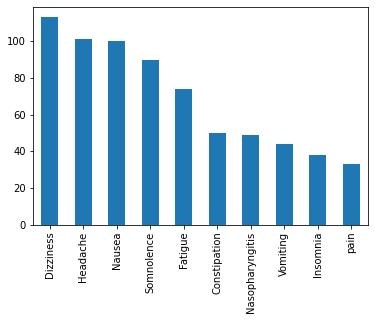

In [63]:
# Let's just try taking out the adjective
def trim_effect(effect):
    tokens = nltk.word_tokenize(effect)
    pos = nltk.pos_tag(tokens)
    
    return '-'.join([x[0] for x in pos if ('n' == x[1][0].lower() or 'v' == x[1][0].lower())])

# 
working_effects['effect_name'].apply(trim_effect).value_counts()[0:10].plot.bar()

<AxesSubplot:>

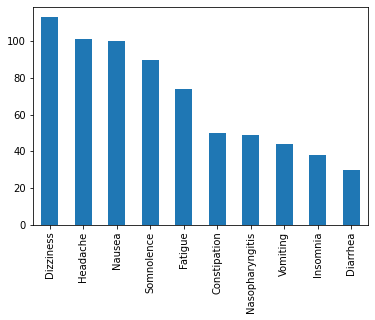

In [64]:
working_effects['effect_name'].value_counts()[0:10].plot.bar()

Looks like from trials the "safest" method for clustering these is:
 - Make sure all the words are tokenized and lower case 
 - Cluster words that are direct synonyms i.e. in the word net 
 - Cluster very similar words that are study-disjoint: TODO 
 
This is all so that we get a low false postive rate that is accurate to the studies 

In [69]:
int_sums

{'Increased sleepiness': 1.0,
 'Emesis': 1.0,
 'Extremity swelling': 2.0,
 'Weight Gain': 9.0,
 'Drowsiness': 28.0,
 'Dizzines': 3.0,
 'irritability': 3.0,
 'dry eyes': 2.0,
 'pain': 1.0,
 'Mood changes': 2.0,
 'Difficulty Concentrating': 2.0,
 'drymouth': 1.0,
 'drug interaction': 1.0,
 'Dizziness': 392.0,
 'Decreased Concentration': 3.0,
 'Edema': 3.0,
 'Sleep Disturbance': 0.0,
 'Ataxia': 30.0,
 'Dry Mouth': 8.0,
 'Fatigue': 145.0,
 'Headache': 276.0,
 'Nausea': 235.0,
 'Rash': 45.0,
 'Hand Tremors': 1.0,
 'Increased Energy': 1.0,
 'Polyuria': 1.0,
 'fatigue': 5.0,
 'somnalence': 5.0,
 'dizziness': 7.0,
 'other': 0.0,
 'Headaches': 9.0,
 'Sweating': 8.0,
 'Hot flashes': 7.0,
 'Nasal congestion': 6.0,
 'Feeling tired/fatigue': 6.0,
 'Feeling drowsy during the day': 8.0,
 'Problems falling asleep': 4.0,
 'Weight gain': 4.0,
 'Stomach/abdominal discomfort': 4.0,
 'Gas': 4.0,
 'Tension': 4.0,
 'Increased interest in sex': 4.0,
 'Waking up too early': 4.0,
 'Coughing': 4.0,
 'Aches, pain

In [79]:
# Loop through effects: add to new affect if above conditions are met
from nltk.corpus import wordnet as wn

def is_same_effect(effectA, effectB):
    if len(effectA.split(' ')) != len(effectB.split(' ')):
        return False
    
    if effectA.lower() == effectB.lower():
        return True
    
    set1 = wn.synsets(effectA.lower())
    set2 = wn.synsets(effectB.lower())
    if not set1 or not set2:
        return False
    
    for word1 in set1:
        for word2 in set2:
            if word1.wup_similarity(word2) == 1:
                return True
    
    return False
    
def aggregate_effects(effects):
    agg = {}
    ledger = []
    for i, primary_effect in enumerate(effects.keys()):
        secondaries = list(effects.keys())
        for j in range(i+1, len(secondaries)):
            secondary_effect = secondaries[j]
            if is_same_effect(primary_effect, secondary_effect):
                if primary_effect not in ledger and secondary_effect not in ledger:
                    if primary_effect not in agg:
                        agg[primary_effect] = effects[primary_effect]

                    agg[primary_effect] += effects[secondary_effect]
                    ledger.append(secondary_effect)
        if primary_effect not in agg and primary_effect not in ledger:
            agg[primary_effect] = effects[primary_effect]
            
    return agg
            

agg_int_sums = aggregate_effects({k: v for k, v in sorted(int_sums.items(), key=lambda item: -1 * item[1])})


<AxesSubplot:>

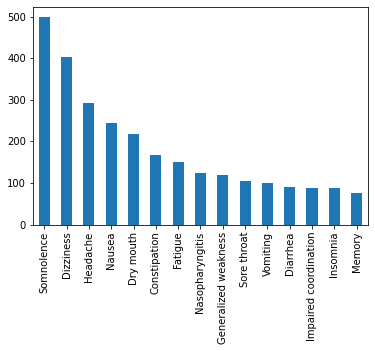

In [80]:
pd.Series(agg_int_sums).sort_values(ascending=False)[0:15].plot.bar()

## Moving data to production
We need to take the data we have collected and use it to fill up our prod tables

We can use this as an opportunity to streamline our process for getting the data

We'll iron out the details in this notebook than make a script to run 


In [149]:
## First drugs
# Get a list
drugs = [
    'Acetaminophen',
    'Adderall',
    'Amitriptyline',
    'Amlodipine',
    'Amoxicillin',
    'Ativan',
    'Atorvastatin',
    'Azithromycin',
    'Benzonatate',
    'Brilinta',
    'Cephalexin',
    'Ciprofloxacin',
    'Citalopram',
    'Clindamycin',
    'Clonazepam',
    'Cyclobenzaprine',
    'Cymbalta',
    'Doxycycline',
    'Dupixent',
    'Entresto',
    'Entyvio',
    'Farxiga',
    'Fentanyl',
    'Gabapentin',
    'Gilenya',
    'Humira',
    'Hydrochlorothiazide',
    'Hydroxychloroquine',
    'Ibuprofen',
    'Imbruvica',
    'Invokana',
    'Januvia',
    'Jardiance',
    'Kevzara',
    'Lexapro',
    'Lisinopril',
    'Loratadine',
    'Lyrica',
    'Melatonin',
    'Meloxicam',
    'Metformin',
    'Methadone',
    'Methotrexate',
    'Metoprolol',
    'Naproxen',
    'Omeprazole',
    'Onpattro',
    'Otezla',
    'Ozempic',
    'Pantoprazole',
    'Prednisone',
    'Rybelsus',
    'Tramadol',
    'Trazodone',
    'Viagra',
    'Wellbutrin',
    'Xanax'
]
# 100 most searched for drugs on drugs.com

def create_drug_prod_table(drugs):
    table = {
        'name': [],
    }
    for drug in drugs:
        table['name'].append(drug)
        
    return pd.DataFrame(table)

create_drug_prod_table(drugs)

,name
0,Acetaminophen
1,Adderall
2,Amitriptyline
3,Amlodipine
4,Amoxicillin
5,Ativan
6,Atorvastatin
7,Azithromycin
8,Benzonatate
9,Brilinta


In [90]:
working_effects

,drug,study_id,group_id,effect_name,type,organ_system,assesment,no_effected,collection_threshold,name,description,participants,is_control,is_intervention
0,gabapentin,NCT01675960,EG000,Increased sleepiness,other,General disorders,Non-systematic Assessment,1.0,0.0,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,2,False,True
1,gabapentin,NCT01675960,EG001,Increased sleepiness,other,General disorders,Non-systematic Assessment,0.0,0.0,Placebo,Glycerin based clear solution that is flavored...,2,True,False
2,gabapentin,NCT01977937,EG000,Emesis,other,Gastrointestinal disorders,Systematic Assessment,1.0,0.0,Gabapentin,Gabapentin 15 milligrams per kilogram will be ...,24,False,True
3,gabapentin,NCT01977937,EG001,Emesis,other,Gastrointestinal disorders,Systematic Assessment,0.0,0.0,Simple Syrup,Simple syrup compounded by the Oregon Health a...,26,False,False
4,gabapentin,NCT02052414,EG000,Extremity swelling,other,Metabolism and nutrition disorders,Systematic Assessment,2.0,0.0,Gralise (Gabapentin ER),An Open label trial with Gralise. All subjects...,31,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075,gabapentin,NCT00667342,EG001,"Pain, lip",other,General disorders,Non-systematic Assessment,1.0,5.0,C: Metastatic Tumors,Stratum C participants had metastatic tumors.,11,False,False
3076,gabapentin,NCT00667342,EG000,"Infection (ANC <1.0 x 10e9/L, fever >38.5 degr...",other,Infections and infestations,Non-systematic Assessment,0.0,5.0,A: Localized Resectable Disease,Stratum A participants had primary tumors pote...,31,False,False
3077,gabapentin,NCT00667342,EG001,"Infection (ANC <1.0 x 10e9/L, fever >38.5 degr...",other,Infections and infestations,Non-systematic Assessment,2.0,5.0,C: Metastatic Tumors,Stratum C participants had metastatic tumors.,11,False,False
3078,gabapentin,NCT00667342,EG000,Infection with normal ANC or Grade 1 or 2 neut...,other,Infections and infestations,Non-systematic Assessment,0.0,5.0,A: Localized Resectable Disease,Stratum A participants had primary tumors pote...,31,False,False


In [104]:
# Now let's load up the effects table we need to do it all at once then remove the duplicates 
def create_prod_effects_table(drugs):
    total_effects = []
    total_effect_groups = []
    try:
        for i, drug in enumerate(drugs):
            studies = get_all_studies(drug)
            effect_groups = pd.DataFrame.from_dict(add_effects_groups(studies))
            effects = pd.DataFrame.from_dict(create_effects_table(studies, drug))

            total_effects.append(effects)
            total_effect_groups.append(effect_groups)
            print(i, " out of ", len(drugs))
            
    except Exception as e:
        print(e)
        
    return pd.concat(total_effects), pd.concat(total_effect_groups)

total_effects, total_effect_groups = create_prod_effects_table(drugs)

0  out of  57
1  out of  57
2  out of  57
3  out of  57
4  out of  57
5  out of  57
6  out of  57
7  out of  57
8  out of  57
9  out of  57
10  out of  57
11  out of  57
12  out of  57
13  out of  57
14  out of  57
15  out of  57
16  out of  57
17  out of  57
18  out of  57
19  out of  57
20  out of  57
21  out of  57
22  out of  57
23  out of  57
24  out of  57
25  out of  57
26  out of  57
27  out of  57
28  out of  57
29  out of  57
30  out of  57
31  out of  57
32  out of  57
33  out of  57
34  out of  57
35  out of  57
36  out of  57
37  out of  57
38  out of  57
39  out of  57
40  out of  57
41  out of  57
42  out of  57
43  out of  57
44  out of  57
45  out of  57
46  out of  57
47  out of  57
48  out of  57
49  out of  57
50  out of  57
51  out of  57
52  out of  57
53  out of  57
54  out of  57
55  out of  57
56  out of  57


In [111]:
# Merge the tables
working_total_effects= total_effects.merge(total_effect_groups.rename(columns={'id': 'group_id'}), 'left', ['study_id', 'group_id']).drop_duplicates(['drug','study_id','group_id','effect_name'])

In [124]:
working_total_effects.head()

,drug,study_id,group_id,effect_name,type,organ_system,assesment,no_effected,collection_threshold,name,description,participants,is_intervention
0,Acetaminophen,NCT00743093,EG000,Ear and labyrinth disorders,other,Ear and labyrinth disorders,Systematic Assessment,3.0,1.0,Acetaminophen Arm,acetaminophen\n\nacetaminophen : 500 mg caplet...,224.0,False
1,Acetaminophen,NCT00743093,EG001,Ear and labyrinth disorders,other,Ear and labyrinth disorders,Systematic Assessment,0.0,1.0,Placebo Arm,"placebo\n\nplacebo : placebo caplets, 2 caplet...",52.0,False
2,Acetaminophen,NCT00743093,EG000,Eye disorders,other,Eye disorders,Systematic Assessment,2.0,1.0,Acetaminophen Arm,acetaminophen\n\nacetaminophen : 500 mg caplet...,224.0,False
3,Acetaminophen,NCT00743093,EG001,Eye disorders,other,Eye disorders,Systematic Assessment,0.0,1.0,Placebo Arm,"placebo\n\nplacebo : placebo caplets, 2 caplet...",52.0,False
4,Acetaminophen,NCT00743093,EG000,Gastrointestinal Disorders,other,Gastrointestinal disorders,Systematic Assessment,70.0,1.0,Acetaminophen Arm,acetaminophen\n\nacetaminophen : 500 mg caplet...,224.0,False


In [126]:
def find_drug_groups_prod(title, drug):
    return drug.lower() in title.lower()

# Mark the effects are have an intervention 
working_total_effects['is_intervention'] = working_total_effects.apply(lambda x: find_drug_groups_prod(x.name, x.drug), axis=1)


AttributeError: 'int' object has no attribute 'lower'

In [139]:
print(drugs[8])
working_total_effects[(working_total_effects['drug'] == 'Benzonatate')]

Benzonatate


,drug,study_id,group_id,effect_name,type,organ_system,assesment,no_effected,collection_threshold,name,description,participants,is_intervention


In [156]:
eff_dict = {
    'name': [],
    'drug': [],
    'percent_effected': [],
    'no_effected': []
}
for i, drug in enumerate(drugs):
    print(i+1, " out of ", len(drugs))
    drug_effects = working_total_effects[(working_total_effects['drug'] == drug)]
    drug_effects['is_intervention'] = drug_effects['name'].apply(lambda x: find_drug_groups_prod(x, drug))
    drug_effects = drug_effects[drug_effects['is_intervention']]
    effect_sums = {}
    drug_effects.apply(lambda x: count_effects(x.effect_name, x.no_effected, effect_sums), axis=1)
    
    aggs = aggregate_effects({k: v for k, v in sorted(effect_sums.items(), key=lambda item: -1 * item[1])})
    
    for_total_sum = drug_effects.drop_duplicates(['study_id'])
    if 'participants' not in for_total_sum.columns:
        continue
        
    at_risk = for_total_sum['participants'].sum()
        
    percent_aggs = {k: (v/at_risk) for (k,v) in aggs.items()}
    
    for (k,v) in percent_aggs.items():
        eff_dict['name'].append(k) 
        eff_dict['drug'].append(i+1) # This is not gonna hold in the future - need an actual way of getting drug ids
        eff_dict['percent_effected'].append(v)
        eff_dict['no_effected'].append(aggs[k])

pd.DataFrame.from_dict(eff_dict)
    
    

1  out of  57


/Users/porterhunley/drugprocessing/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


2  out of  57
3  out of  57
4  out of  57
5  out of  57
6  out of  57
7  out of  57
8  out of  57
9  out of  57
10  out of  57
11  out of  57
12  out of  57
13  out of  57
14  out of  57
15  out of  57
16  out of  57
17  out of  57
18  out of  57
19  out of  57
20  out of  57
21  out of  57
22  out of  57
23  out of  57
24  out of  57
25  out of  57
26  out of  57
27  out of  57
28  out of  57
29  out of  57
30  out of  57
31  out of  57
32  out of  57
33  out of  57
34  out of  57
35  out of  57
36  out of  57
37  out of  57
38  out of  57
39  out of  57
40  out of  57
41  out of  57
42  out of  57
43  out of  57
44  out of  57
45  out of  57
46  out of  57
47  out of  57
48  out of  57
49  out of  57
50  out of  57
51  out of  57
52  out of  57
53  out of  57
54  out of  57
55  out of  57
56  out of  57
57  out of  57


,name,drug,percent_effected,no_effected
0,Nausea,1,0.203779,1057.0
1,Vomiting,1,0.103142,535.0
2,Constipation,1,0.085791,445.0
3,Dizziness,1,0.068826,357.0
4,Headache,1,0.055331,287.0
...,...,...,...,...
13300,Hypotensive shock,54,0.000000,0.0
13301,Hypotension,54,0.000000,0.0
13302,Hypotension with convulsions,54,0.000000,0.0
13303,Myalgia intercostal,54,0.000000,0.0


In [159]:
prod_effects = pd.DataFrame.from_dict(eff_dict).rename(columns={'drug': 'drug_id'})
prod_effects.head()

,name,drug_id,percent_effected,no_effected
0,Nausea,1,0.203779,1057.0
1,Vomiting,1,0.103142,535.0
2,Constipation,1,0.085791,445.0
3,Dizziness,1,0.068826,357.0
4,Headache,1,0.055331,287.0


In [152]:
# Upload these tables to sqlalchemy 
from sqlalchemy import create_engine

engine = create_engine('sqlite:////Users/porterhunley/mediboard/site-logic/app.db')
connection = engine.connect()

In [153]:
drugs_df = create_drug_prod_table(drugs)

In [155]:
drugs_df.to_sql('drug', connection, index=False, if_exists='append')

In [160]:
prod_effects.to_sql('effect', connection, index=False, if_exists='append')

### Streamlining 

Let's get our table creation into a single function taking in a drug 

In [88]:
def get_all_studies(expr, results=True):
    og_length = 99
    studies = []
    count = 0
    while (og_length >= 99):
        r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk={min_rank}&max_rnk={max_rank}&fmt=json'
                         .format(expr=expr, min_rank=count*99 + 1, max_rank=(count*99+1)+98))
        og_length = len(r.json()['FullStudiesResponse'].get('FullStudies', []))
        new_studies = r.json()['FullStudiesResponse'].get('FullStudies', [{'Study': []}])
        studies += list(filter(lambda x: 'ResultsSection' in x['Study'] and 'OutcomeMeasuresModule' in x['Study']['ResultsSection'], new_studies))
        count+=1
        
    return studies

In order for this to work we need a way to identify what interventions are in each study

In [ ]:
def create_all_tables(drug):
    studies = get_all_studies(drug)
    studies_table = pd.DataFrame.from_dict(create_studies_table(studies))
    groups_table = pd.DataFrame.from_dict(create_groups_table(studies))
    measures_table = pd.DataFrame.from_dict(create_measures_table(studies))
    admin_df, outcome_df = create_outcomes_table(studies)
    admins_table = pd.DataFrame.from_dict(admin_df)
    outcomes_table = pd.DataFrame.from_dict(outcome_df)
    
    